# Credit Card Fraud Detection
Author: Shanrong Zhou

Every year billions of dollars are lost in the US due to credit card fraud. Thus, forcing financial institutions to continuously improve their fraud detection systems. In recent years, machine learning and data mining techniques are being used to address this problem.
- Objectives: This report uses a real dataset to conduct credit card fraud detection. Previously, I've finished the Feature Engineering and created new features in the previous project, <a href="Shanrong%20Zhou_Report_Feature-Engineering-&-EDA-Assignment-2.html">Feature Engineering (FE) & EDA for Credit Card Fraud Detection</a>. In this project, I will use unsupervised learning methods (HBOS and ECOD) to revise the features and identify anomalous credit card transactions.
- Dataset: The dataset contains information on purchases made through the purchase card programs administered by the state and higher education institutions in the State of Oklahoma. It includes both the raw data fields and new variables created by the previous feature engineering process. 

# Table of Contents
- [Section 1 Data Preparation](#1)
  - [1.1 Understanding Data](#11)
  - [1.2 Data Splitting](#12)
  - [1.3 Exploratory Data Analysis (EDA)](#13)
- [Section 2 Revising Feature Engineering](#2)
  - [2.1 Benchmark Investigation](#21)
  - [2.2 Revised Features](#22)
  - [2.3 Data Splitting](#23)
  - [2.4 Exploratory Data Analysis (EDA)](#24)
- [Section 3 Histogram-based Outlier Score (HBOS)](#3)
  - [3.1 Build the model](#31)
  - [3.2 Determine the threshold](#32)
  - [3.3 Descriptive statistics](#33)
  - [3.4 Fine-tuning HBOS Model](#34)
      - [3.4.1 Feature Selection](#341)
      - [3.4.2 Testing number of bins](#342)
  - [3.5 Achieve model stability by aggregating multiple models](#35)
- [Section 4 Empirical Cumulative Outlier Detection (ECOD)](#4)
  - [4.1 Build the model](#41)
  - [4.2 Determine the threshold](#42)
  - [4.3 Descriptive statistics](#43)
- [Section 5 Conclusion](#5)
  - [5.1 Outliers Identified by Multiple Models](#51)
  - [5.2 Explain the Outlier Score of an Observation](#52)

## Section 1 Data Preparation <a class="anchor" id="1"></a>

###  1.1 Understanding Data<a class="anchor" id="11"></a>

Basic business understandings of the raw data:
- Each row is a transaction of a cardholder (last name + first name).
- An agency can have multiple cardholders. A corporate card (agency_name) can be used by many cardholders and these cardholders have to follow the corporation policy.
- An agency and its cardholders can spend on various merchant categories, vendors and uses/transaction types (description). 

The new features (last 16 variables) are created by Transaction Aggregation Strategy, which is grouping the transactions made during the Fiscal Year 2014:
- first by agency name and card holder name level 
- then by different combinations of merchant category, vendor, description, and time frame
- followed by calculating the total amount spent on those transactions

After the transaction aggregation, then the average or median amount is calculated as the benchmark for single transaction comparison. The new variable is the ratio of single transaction's amount to the benchmark.

In [1]:
# Import credit card data after feature engineering 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
path = '/Users/alicezhou/Documents/Columbia/5420 Anomaly Detection/5. EDA Best Practices/Assignment 5/' 
df = pd.read_csv(path + 'credit_card_fe.csv') 
df_copy = df.copy() # Save a copy of dataset including raw data fields and new variables
df.head(5)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,...,agency_description_day_avg_ratio_amount,agency_description_day_median_ratio_amount,agency_vendor_month_avg_ratio_amount,agency_vendor_month_median_ratio_amount,agency_vendor_day_avg_ratio_amount,agency_vendor_day_median_ratio_amount,agency_merchant_description_avg_ratio_amount,agency_merchant_description_median_ratio_amount,agency_merchant_vendor_avg_ratio_amount,agency_merchant_vendor_median_ratio_amount
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,...,2.702795,8.169260,1.135566,1.000000,1.233256,1.000000,2.200018,3.560000,1.243789,1.318519
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,...,1.033089,2.123633,1.064881,1.064881,1.032701,1.000000,0.830193,1.074182,0.781845,1.795426
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,...,0.537288,1.614999,1.000000,1.000000,1.495491,1.495491,0.382922,1.064723,1.801787,6.380146
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,...,0.292722,0.884758,1.593246,2.686455,1.630422,2.707584,1.612690,2.972248,1.544294,2.710249
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,...,1.000000,1.000000,0.755700,1.078748,1.124295,1.650203,1.784894,1.726189,0.876658,1.682158


In [2]:
# Check dimensions of the dataset, and we found it has 442,458 rows and 31 columns 
print(df.shape)
print(df.columns) # Check column names

(442458, 31)
Index(['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
       'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor',
       'Transaction_Date', 'Posted_Date', 'Merchant_Category', 'Year', 'Month',
       'Week_Number', 'Day_of_Week', 'agency_merchant_month_avg_ratio_amount',
       'agency_merchant_month_median_ratio_amount',
       'agency_merchant_day_avg_ratio_amount',
       'agency_merchant_day_median_ratio_amount',
       'agency_description_month_avg_ratio_amount',
       'agency_description_month_median_ratio_amount',
       'agency_description_day_avg_ratio_amount',
       'agency_description_day_median_ratio_amount',
       'agency_vendor_month_avg_ratio_amount',
       'agency_vendor_month_median_ratio_amount',
       'agency_vendor_day_avg_ratio_amount',
       'agency_vendor_day_median_ratio_amount',
       'agency_merchant_description_avg_ratio_amount',
       'agency_merchant_description_median_ratio_amount',
       'agency_merc

Feature Engineering Summary:
- Feature 1: The ratio to average amount (grouping by agency, merchant category and month)
- Feature 2: The ratio to median amount (grouping by agency, merchant category and month)
- Feature 3: The ratio to average amount (grouping by agency, merchant category and day of week)
- Feature 4: The ratio to median amount (grouping by agency, merchant category and day of week)
- Feature 5: The ratio to average amount (grouping by agency, description and month)
- Feature 6: The ratio to median amount (grouping by agency, description and month)
- Feature 7: The ratio to average amount (grouping by agency, description and day of week )
- Feature 8: The ratio to median amount (grouping by agency, description and day of week)
- Feature 9: The ratio to average amount (grouping by agency, vendor and month)
- Feature 10: The ratio to median amount (grouping by agency, vendor and month)
- Feature 11: The ratio to average amount (grouping by agency, vendor and day of week)
- Feature 12: The ratio to median amount (grouping by agency, vendor and day of week)
- Feature 13: The ratio to average amount (grouping by agency, merchant category and description)
- Feature 14: The ratio to median amount (grouping by agency, merchant category and description)
- Feature 15: The ratio to average amount (grouping by agency, merchant category and vendor)
- Feature 16: The ratio to median amount (grouping by agency, merchant category and vendor)

Based on the raw data fields, the 16 new features have captured the consumer spending patterns. I've used visualization and transaction analysis to show the effectiveness of the new features. They are more informative for anomaly detection. I will use these new features in credit card fraud detection subsequently, and remove the other variables to reduce noise and improve the model's performance. 

In [3]:
# Only keep the new features for further anolmaly detection
df = df.iloc[:,-16:] 

In [4]:
# Check missing values, and there's no missing value in the dataset 
df.isnull().sum()

agency_merchant_month_avg_ratio_amount             0
agency_merchant_month_median_ratio_amount          0
agency_merchant_day_avg_ratio_amount               0
agency_merchant_day_median_ratio_amount            0
agency_description_month_avg_ratio_amount          0
agency_description_month_median_ratio_amount       0
agency_description_day_avg_ratio_amount            0
agency_description_day_median_ratio_amount         0
agency_vendor_month_avg_ratio_amount               0
agency_vendor_month_median_ratio_amount            0
agency_vendor_day_avg_ratio_amount                 0
agency_vendor_day_median_ratio_amount              0
agency_merchant_description_avg_ratio_amount       0
agency_merchant_description_median_ratio_amount    0
agency_merchant_vendor_avg_ratio_amount            0
agency_merchant_vendor_median_ratio_amount         0
dtype: int64

###  1.2 Data Splitting <a class="anchor" id="12"></a>

To assess how effectively our machine learning model works, we usually divide a dataset into training and testing sets. 

In [1]:
# Data split for train and test
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, random_state=0)

NameError: name 'df' is not defined

###  1.3 Exploratory Data Analysis (EDA) <a class="anchor" id="13"></a>

Before building models, EDA will be conducted to explore the statistical patterns of the features. All the features are numeric variables. Therefore, I will have a look at the statistics summary and distribution plots of these variables. 

In [6]:
# Get the Simple Summary Statistics of all variables 
X_train.describe()

,agency_merchant_month_avg_ratio_amount,agency_merchant_month_median_ratio_amount,agency_merchant_day_avg_ratio_amount,agency_merchant_day_median_ratio_amount,agency_description_month_avg_ratio_amount,agency_description_month_median_ratio_amount,agency_description_day_avg_ratio_amount,agency_description_day_median_ratio_amount,agency_vendor_month_avg_ratio_amount,agency_vendor_month_median_ratio_amount,agency_vendor_day_avg_ratio_amount,agency_vendor_day_median_ratio_amount,agency_merchant_description_avg_ratio_amount,agency_merchant_description_median_ratio_amount,agency_merchant_vendor_avg_ratio_amount,agency_merchant_vendor_median_ratio_amount
count,3.318430e+05,331843.000000,3.318430e+05,331843.000000,3.318430e+05,331843.000000,331843.000000,331843.000000,3.318430e+05,331843.000000,3.318430e+05,331843.000000,3.318430e+05,331843.000000,3.318430e+05,331843.000000
mean,-7.376098e+10,5.870590,-2.071686e+12,6.090778,1.005570e+00,2.952627,1.007136,2.928053,-1.515406e+11,1.871386,9.912071e-01,1.852911,1.054334e+11,4.992865,-9.518112e+10,1.843629
std,4.249061e+13,1380.737489,3.217077e+15,1465.982493,6.157003e+13,47.198979,7.412656,44.779618,3.873840e+14,113.099322,3.175014e+13,111.241197,2.024743e+14,1249.702175,2.199536e+14,24.090302
min,-2.447706e+16,-29642.000000,-5.875565e+17,-10476.000000,-2.527153e+16,-614.184815,-718.213058,-643.639167,-1.266826e+17,-2087.333333,-1.379579e+16,-6336.000000,-6.275203e+16,-59114.000000,-6.944551e+16,-683.920000
25%,2.022276e-01,0.500000,1.944819e-01,0.493491,1.707206e-01,0.573119,0.169839,0.567981,4.636496e-01,0.821576,4.290902e-01,0.783943,3.198103e-01,0.695700,3.412282e-01,0.659342
50%,5.992825e-01,1.000000,5.742413e-01,1.000000,8.414379e-01,1.000000,0.819350,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,9.251370e-01,1.000000,9.582556e-01,1.000000
75%,1.125000e+00,1.913560,1.116372e+00,1.980510,1.000000e+00,1.662542,1.000000,1.675287,1.000000e+00,1.170305,1.000000e+00,1.235662,1.000000e+00,1.415125,1.041549e+00,1.445482
max,2.277000e+03,598420.505983,5.875565e+17,608261.460064,2.488309e+16,19230.892626,2682.359399,17517.814051,1.263193e+17,63226.000000,1.184939e+16,63226.000000,6.275203e+16,528116.052705,6.424385e+16,13119.000000


We can see the quartiles of all the variables are quite different from each other. Some variables (eg. agency_merchant_month_median_ratio_amount) have small averages (eg. 5.87) but very large standard deviations (eg. 1380.74). The values of these variables can be significantly dispersed.

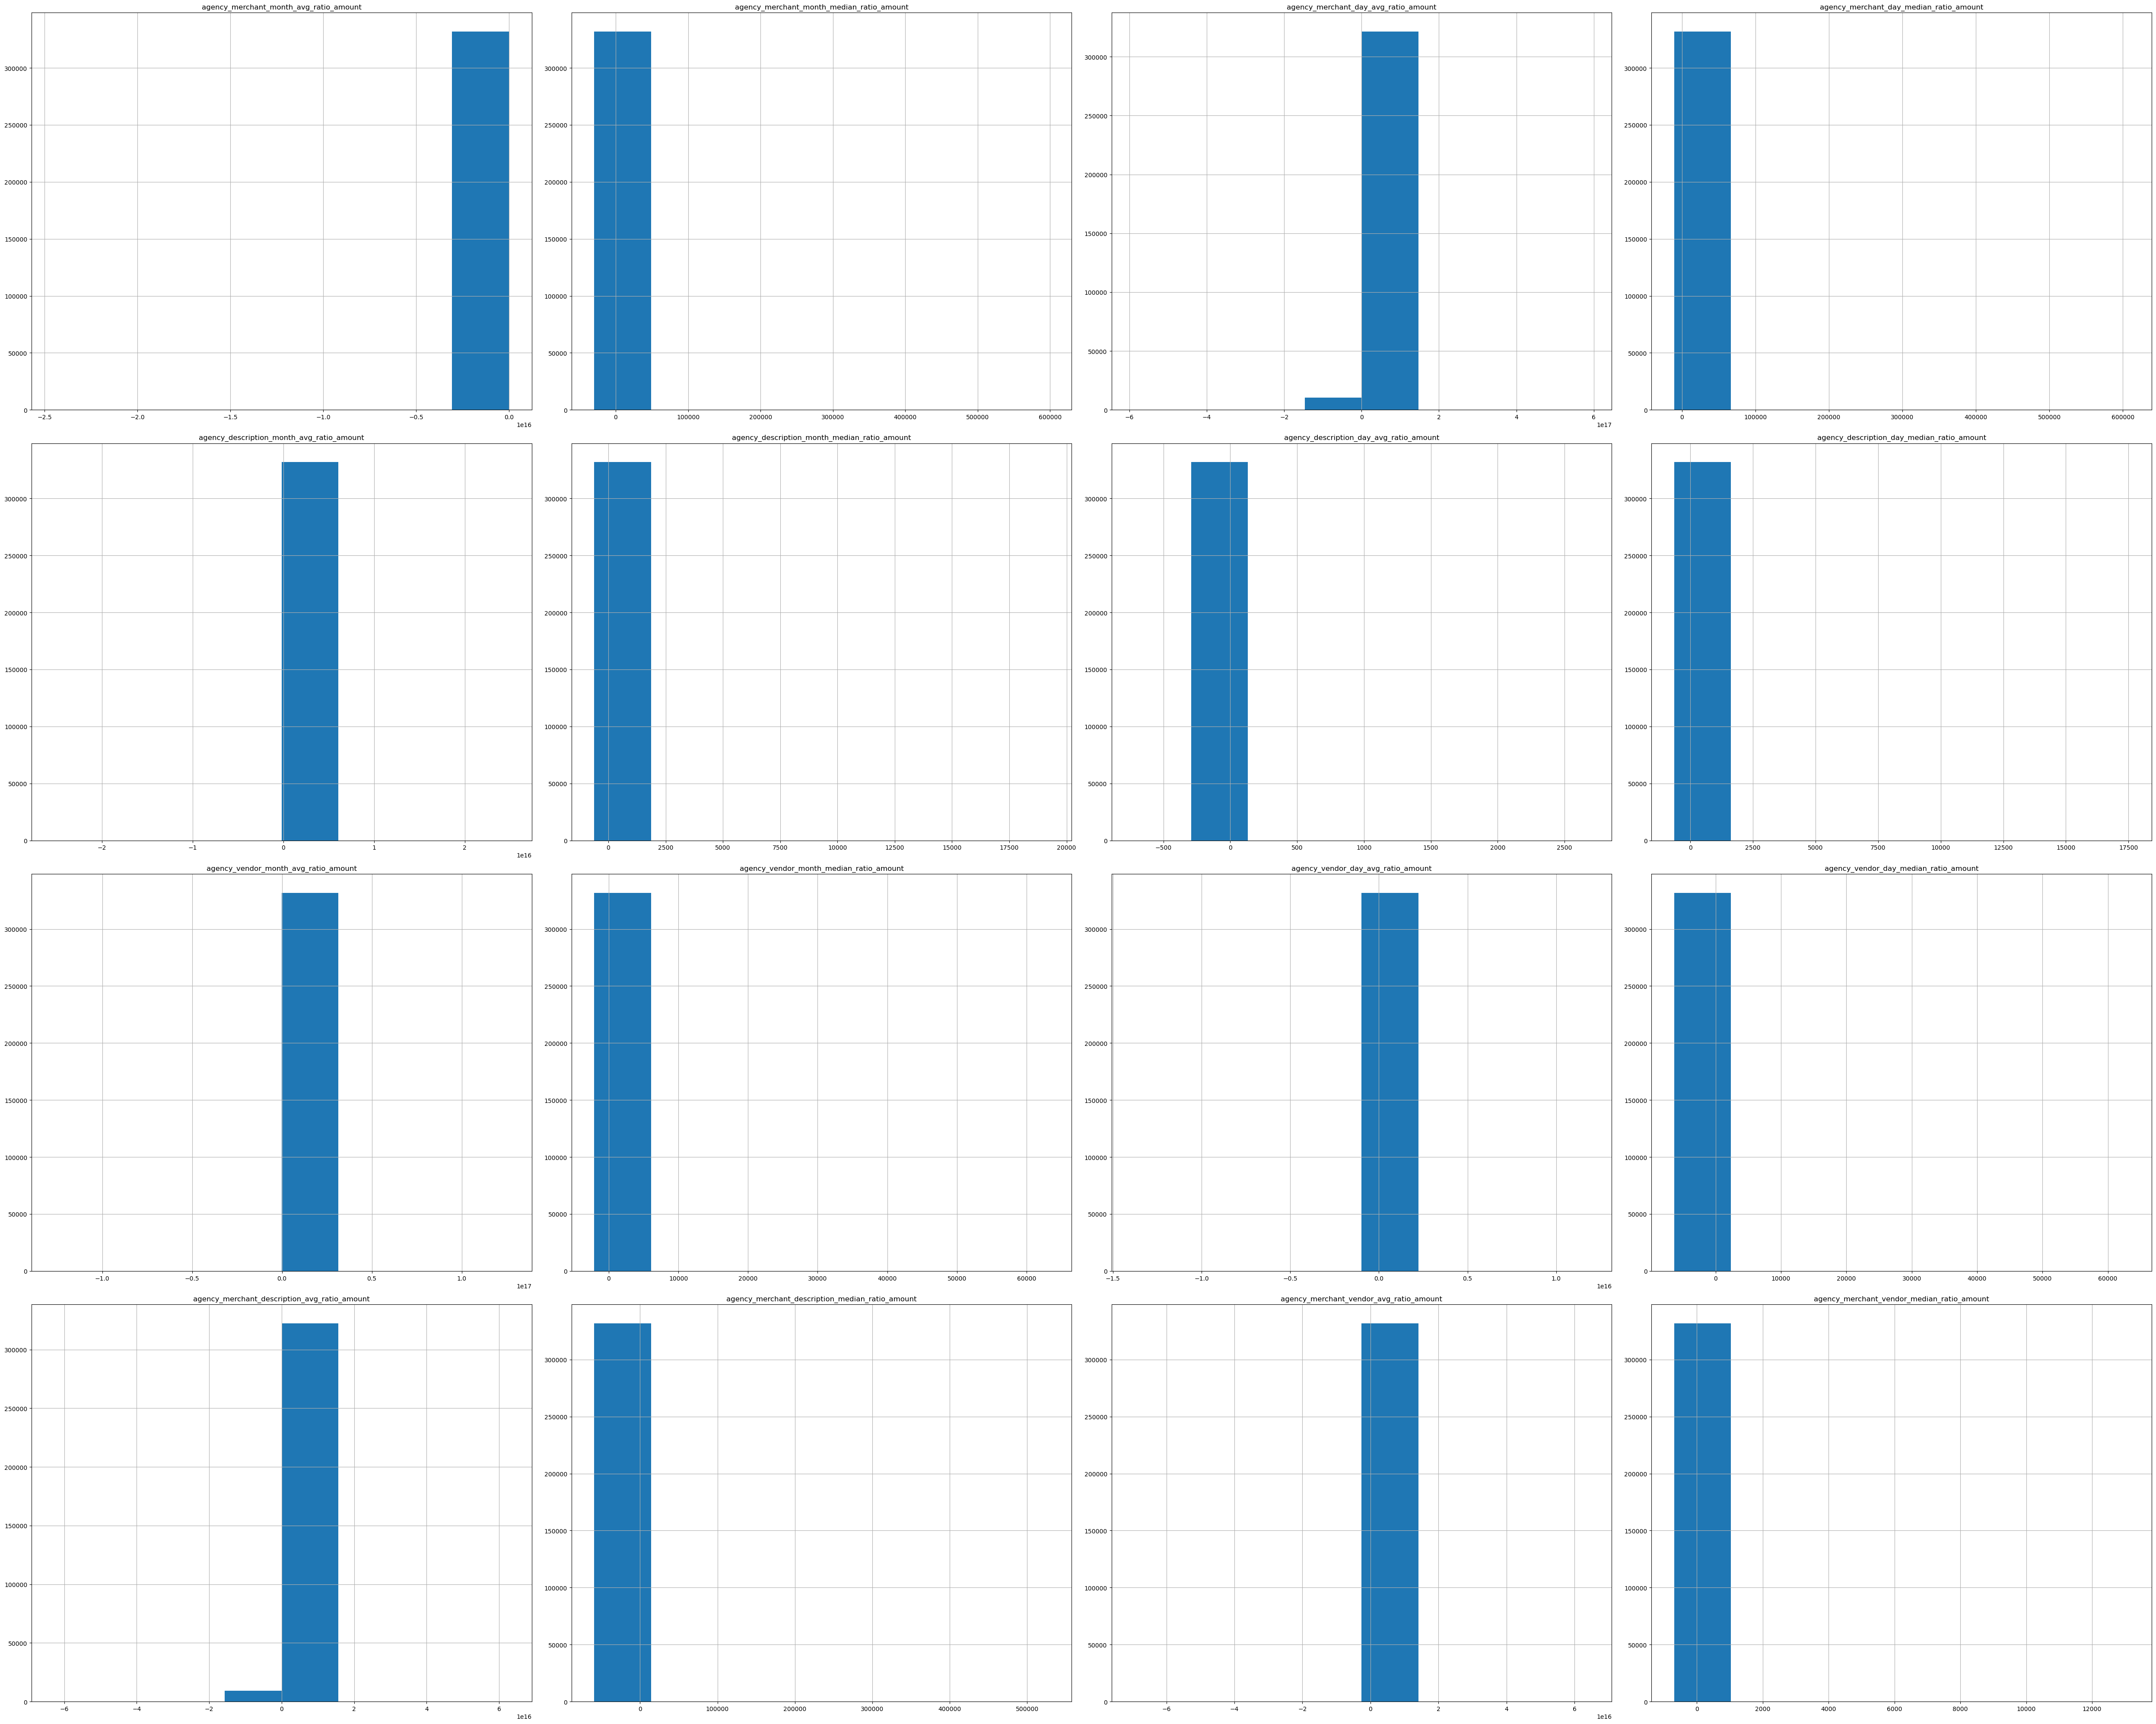

In [7]:
# Plot the distribution of all variables, setting number of bins as 8
X_train.hist(bins=8, figsize=(50, 40))
plt.tight_layout()
plt.show()

We cannot clearly see the dispersement reflected by the plots. There are too many transactions having near average values to make the dispersed values significantly shown. Therefore, I will use specific percentile to bin these variables and show the dispersed values more clearly.

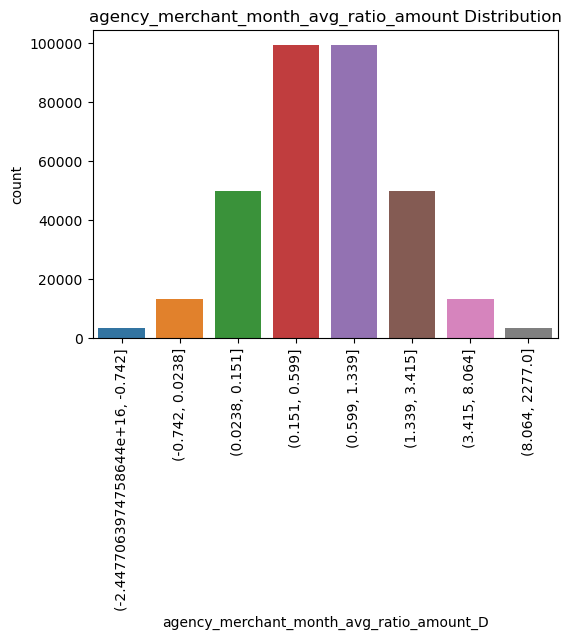

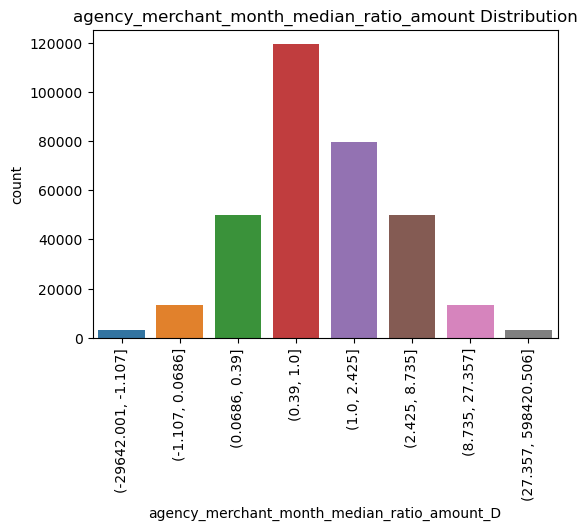

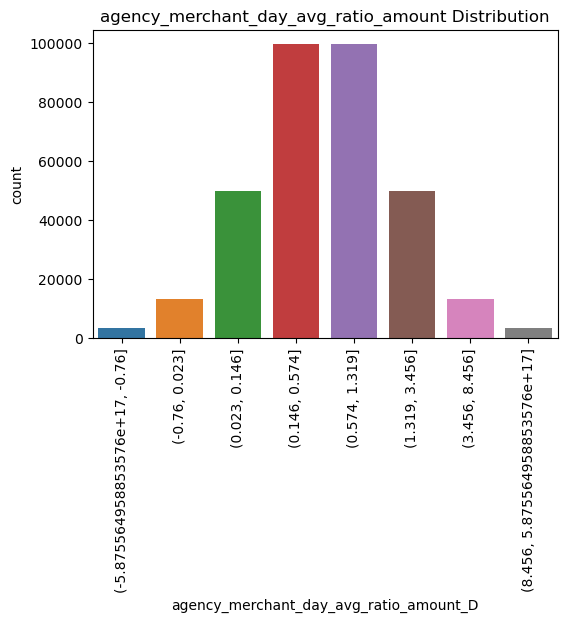

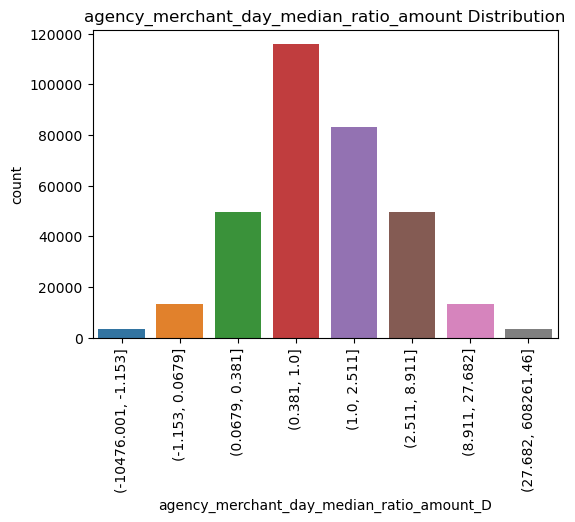

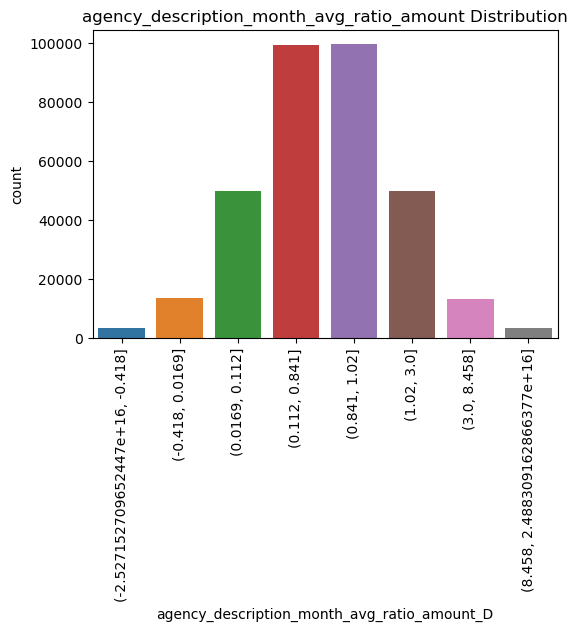

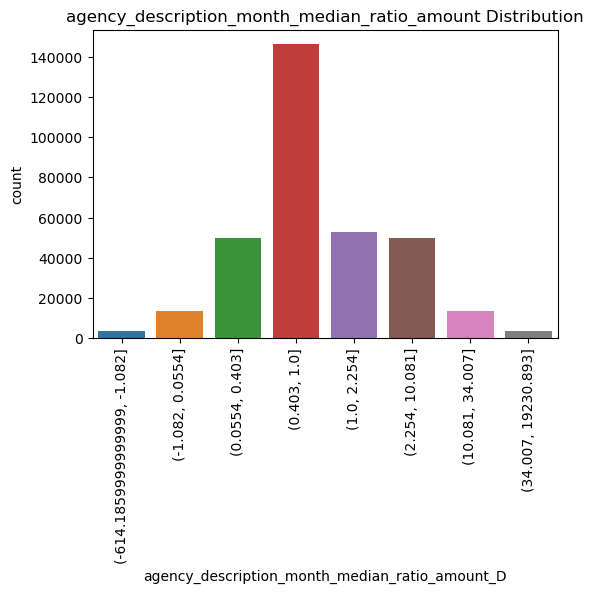

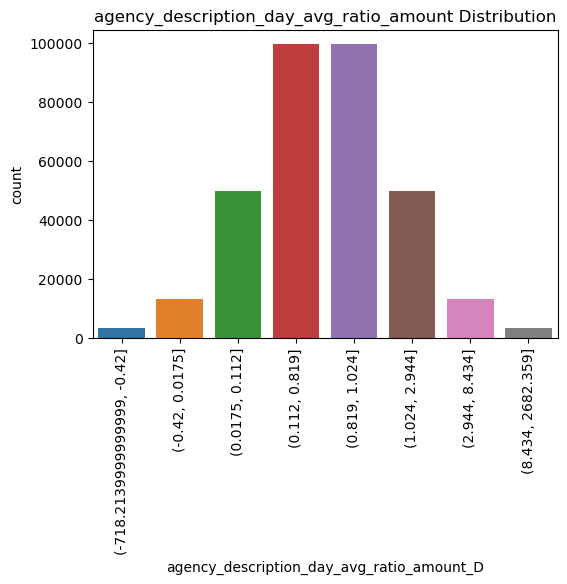

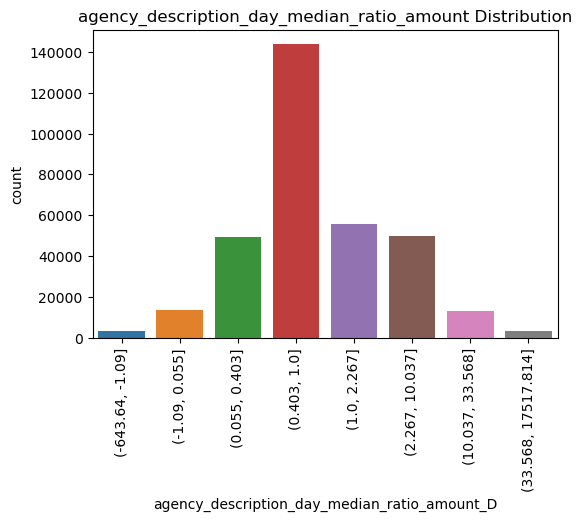

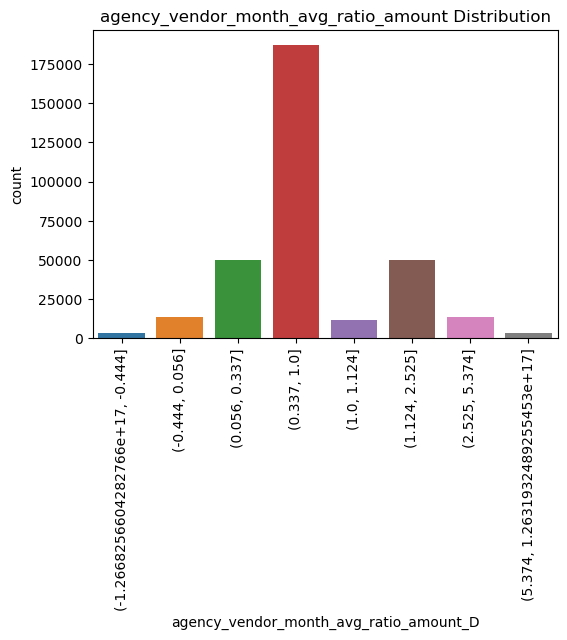

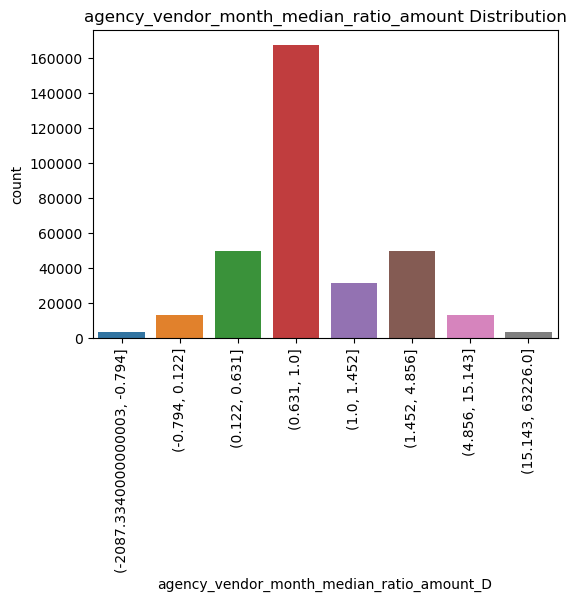

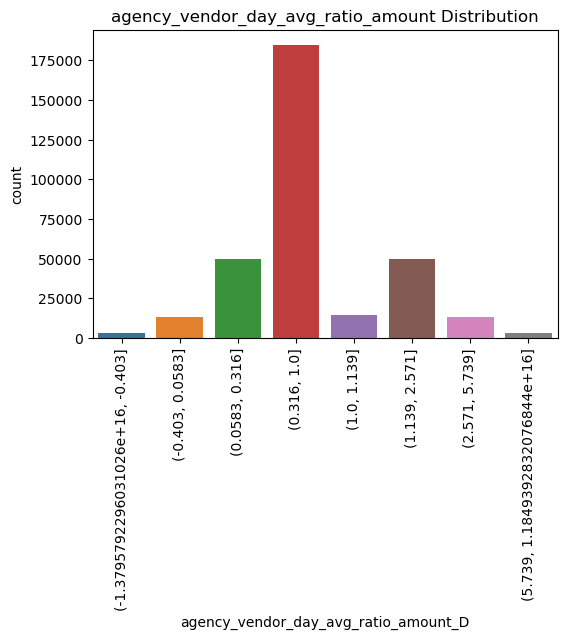

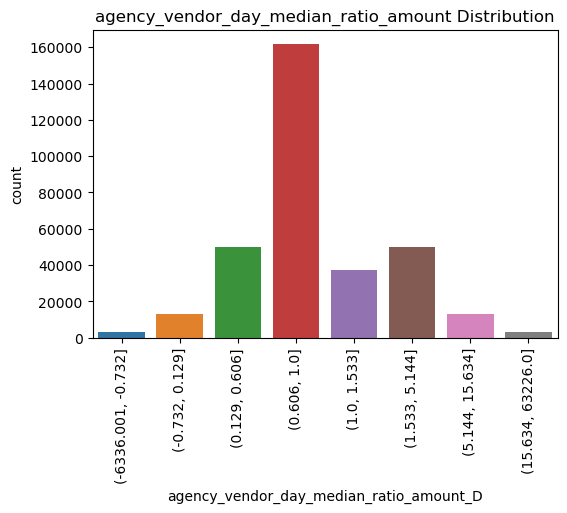

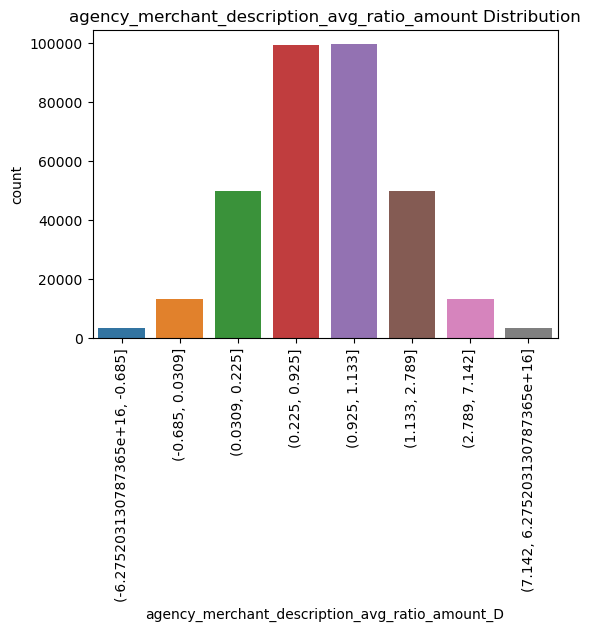

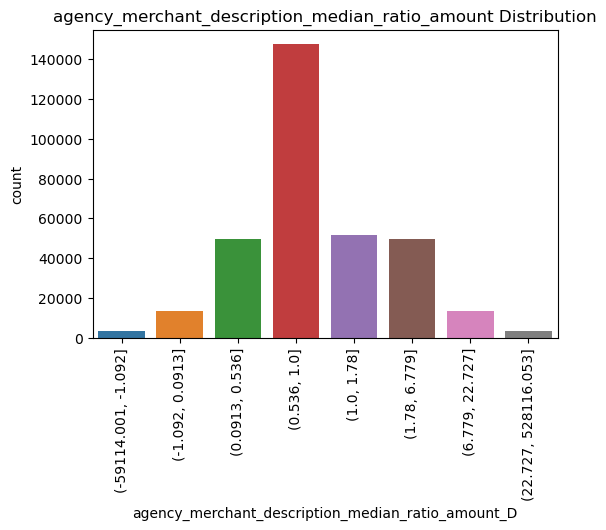

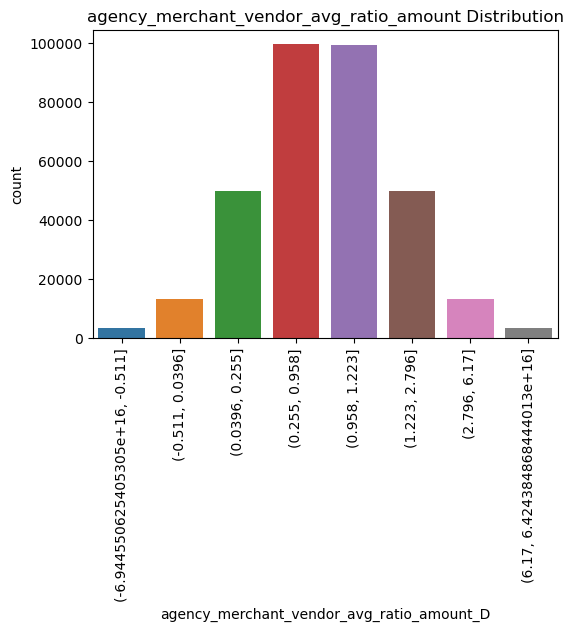

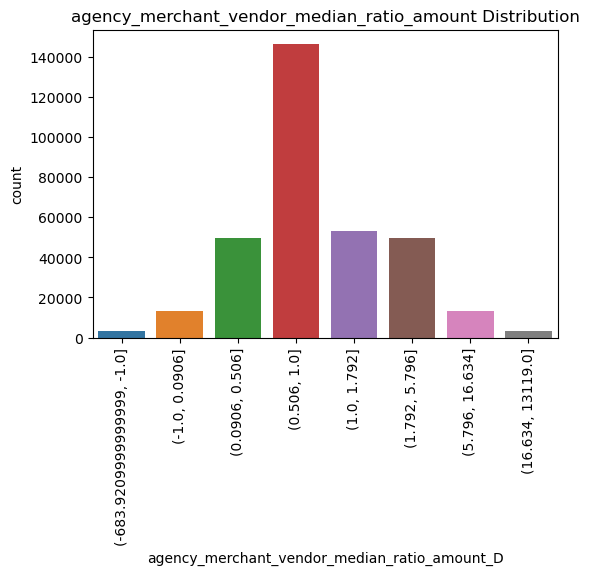

In [8]:
# Plot the distribution of all variables, binning with specific percentile 
X_train_D=X_train.copy()
for col in X_train_D.select_dtypes(include='number').columns:
    binned_var = col + '_D'

    # Sepefic percentiles: 
    ## 0 and 1 represent the minimum and maximum values
    ## 0.01, 0.05, 0.95, and 0.99 identify nearly extreme values (outliers)
    ## 0.2, 0.5, and 0.8 represent near quartiles values 
    percentile = [0, 0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99, 1]
    
    X_train_D[binned_var] = pd.qcut(X_train_D[col], percentile)
    plt.figure(figsize=(6, 4))
    g = sns.countplot(x=binned_var, data=X_train_D)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(col + ' Distribution')
    plt.show()

Binning the variables with specific percentiles can clearly show the nearly extremely dispersed values (outliers) in distribution plots. We've also discussed the anomalous transactions identified from the outliers in these distribution plots during feature engineering process. However, the distribution plots also suggest that all the variables are highly concentrated around the average, and there are few extreme values. Next, to estimate the distribution empirically, I will use ECDF() in the Python statmodels module to derive the cumulative distribution function (CDF).

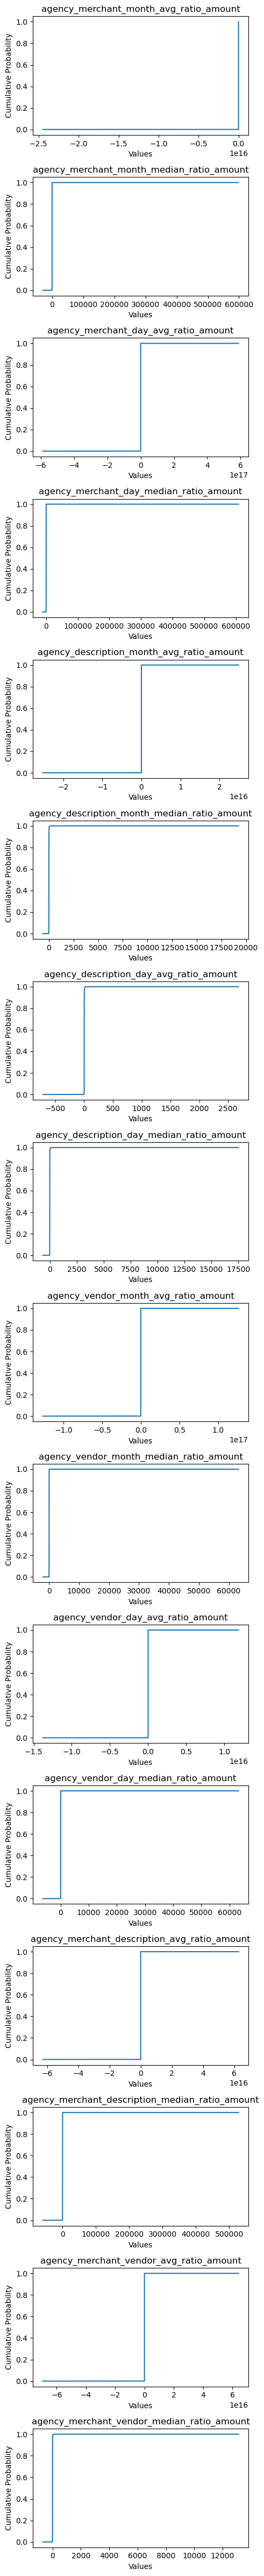

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF

# Get the list of numeric columns
numeric_cols = X_train.select_dtypes(include='number').columns

# Create separate plots for each numeric variable
num_plots = len(numeric_cols)
fig, axes = plt.subplots(num_plots, 1, figsize=(5, 3*num_plots))

# Plot the CDF for each numeric column
for i, col in enumerate(numeric_cols):
    # Fit the ECDF
    ecdf = ECDF(X_train[col])
    
    # Plot the CDF in the corresponding subplot
    axes[i].plot(ecdf.x, ecdf.y)
    axes[i].set_title(col)
    
    # Set the x and y labels for each plot
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Cumulative Probability')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


CDF shows that there's a significant increase from nearly 0% to nealy 100%, while crossing the average value. It suggests that all the variables have extremely low amounts of nearly extreme values, and extremely large amounts of nearly average values. 

The above EDA process suggests that data after feature engineering is at a very high level of granularity. All the variables exhibit a highly concentrated distribution around the average with few extreme values. However, HBOS and ECOD rely on binning the data into intervals or bins to estimate the underlying data distribution. With high data granularity, more bins are needed to capture the finer variations in the data. It may become challenging to ensure sufficient data points within each bin, especially for rare events or outliers, which can impact the accuracy of the model's estimation. Therefore, I will revise the feature engineering, in order to enhance the performance of the models.

## Section 2 Revising Feature Engineering <a class="anchor" id="2"></a>

To achieve a more reasonable data granularity, I will try to decrease the specificity of transaction aggregation groups, and then check the credibility of the benchmark. In another word, I will investigate the count of each category after transaction aggregation. If the count is mostly 1.0, that means the benchmarks are created out of a data point and are not credible.

###  2.1 Benchmark Investigation <a class="anchor" id="21"></a> 

In [10]:
# Revert to the dataset with only raw data fields 
df = df_copy.iloc[:,:-16] 

For the previous feature engineerning, I am going to check the distribution of each category's Count in the transaction aggregation group. 

In [11]:
# 1 Grouping by agency, merchant category and month
group1 = pd.DataFrame(df.groupby(['Agency_Name', 'Merchant_Category','Month']).size())
group1.columns = ['Count']
print(group1.describe())
# 2 Grouping by agency, merchant category and day of week
group2 = pd.DataFrame(df.groupby(['Agency_Name', 'Merchant_Category','Day_of_Week']).size())
group2.columns = ['Count']
print(group2.describe())
# 3 Grouping by agency, description and month
group3 = pd.DataFrame(df.groupby(['Agency_Name', 'Description','Month']).size())
group3.columns = ['Count']
print(group3.describe())
# 4 Grouping by agency, description and day of week
group4 = pd.DataFrame(df.groupby(['Agency_Name', 'Description','Day_of_Week']).size())
group4.columns = ['Count']
print(group4.describe())
# 5 Grouping by agency, vendor and month
group5 = pd.DataFrame(df.groupby(['Agency_Name', 'Vendor','Month']).size())
group5.columns = ['Count']
print(group5.describe())
# 6 Grouping by agency, vendor and day of week
group6 = pd.DataFrame(df.groupby(['Agency_Name', 'Vendor','Day_of_Week']).size())
group6.columns = ['Count']
print(group6.describe())
# 7 Grouping by agency, merchant category and description
group7 = pd.DataFrame(df.groupby(['Agency_Name', 'Merchant_Category','Description']).size())
group7.columns = ['Count']
print(group7.describe())
# 8 Grouping by agency, merchant category and vendor
group8 = pd.DataFrame(df.groupby(['Agency_Name', 'Merchant_Category','Vendor']).size())
group8.columns = ['Count']
print(group8.describe())

              Count
count  39888.000000
mean      11.092509
std       39.448358
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max      857.000000
              Count
count  27574.000000
mean      16.046203
std       69.780030
min        1.000000
25%        1.000000
50%        3.000000
75%        7.000000
max     1553.000000
               Count
count  121441.000000
mean        3.643399
std        77.899874
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      7263.000000
               Count
count  115178.000000
mean        3.841515
std       117.338521
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max     15868.000000
               Count
count  189209.000000
mean        2.338462
std         9.523202
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       431.000000
               Count
count  166529.000000
mean        2.656943
std       

The statistics show that all the groups have a same issue. Counts of each category mostly are very low. Looking at their quantiles, most of the medians are closed to 1 and even some of the 75th percentiles are also closed to 1. These groups of trasaction aggregation will make the data too granular to analyse. It indicates that the benchmarks are created out of a data point and not credible.

I will aggregate transactions with only 2 levels of features, and check the distribution of each category's Count in the transaction aggregation group, before starting revised feature engineering. 

In [12]:
# 1 Grouping by agency + merchant category 
group1 = pd.DataFrame(df.groupby(['Agency_Name', 'Merchant_Category']).size())
group1.columns = ['Count']
print(group1.describe())
# 2 Grouping by agency + day of week
group2 = pd.DataFrame(df.groupby(['Agency_Name', 'Day_of_Week']).size())
group2.columns = ['Count']
print(group2.describe())
# 3 Grouping by agency + month
group3 = pd.DataFrame(df.groupby(['Agency_Name', 'Month']).size())
group3.columns = ['Count']
print(group3.describe())
# 4 Grouping by card holder + merchant category 
group4 = pd.DataFrame(df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Merchant_Category']).size())
group4.columns = ['Count']
print(group4.describe())
# 5 Grouping by card holder + day of week
group5 = pd.DataFrame(df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Day_of_Week']).size())
group5.columns = ['Count']
print(group5.describe())
# 6 Grouping by card holder + month
group6 = pd.DataFrame(df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Month']).size())
group6.columns = ['Count']
print(group6.describe())
# 7 Grouping by merchant category + day of week
group7 = pd.DataFrame(df.groupby(['Merchant_Category','Day_of_Week']).size())
group7.columns = ['Count']
print(group7.describe())
# 8 Grouping by merchant category + month
group8 = pd.DataFrame(df.groupby(['Merchant_Category','Month']).size())
group8.columns = ['Count']
print(group8.describe())

             Count
count  8427.000000
mean     52.504806
std     297.900980
min       1.000000
25%       2.000000
50%       5.000000
75%      17.000000
max    8102.000000
              Count
count    805.000000
mean     549.637267
std     2229.869758
min        1.000000
25%       13.000000
50%       52.000000
75%      191.000000
max    23475.000000
              Count
count   1287.000000
mean     343.790210
std     1215.544473
min        1.000000
25%       13.000000
50%       44.000000
75%      138.000000
max    10763.000000
              Count
count  69053.000000
mean       6.407513
std       34.822891
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max     4481.000000
              Count
count  28222.000000
mean      15.677769
std       46.485797
min        1.000000
25%        2.000000
50%        6.000000
75%       16.000000
max     2205.000000
              Count
count  42164.000000
mean      10.493739
std       25.564452
min        1.000000
25%      

The statistics show that the revised trasaction aggregation groups have addressed the above issue. The grouping methods are still meaningful, while counts of each category have increased overall. All the medians are now deviated from 1. Data should be at a more reasonable level of granularity. Therefore, I will continue to use these groups to revise the feature engineering process. 

###  2.2 Revised Features <a class="anchor" id="22"></a> 

I will use the same feature engineering process, Transaction Aggregation Strategy, to create the new features. Here are an overview of the 8 groups: 
- Corporate spending patterns:
    1. Grouping by agency + merchant category 
    2. Grouping by agency + day of week
    3. Grouping by agency + month
- Personal spending patterns:
    4. Grouping by card holder + merchant category 
    5. Grouping by card holder + day of week
    6. Grouping by card holder + month
- Consuming category spending patterns:
    7. Grouping by merchant category + day of week
    8. Grouping by merchant category + month 

After the transaction aggregation, then the average or median amount is calculated as the benchmark for single transaction comparison. The new variable is the ratio of single transaction's amount to the benchmark.

In [13]:
# Feature 1: The ratio to average amount (grouping by agency + merchant category)
# create benchmark
stat1 = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
stat1 = pd.DataFrame(stat1)
stat1.columns = ['AVG_amount']
# add the new feature to the dataset 
df1 = pd.merge(df, stat1, how='left', on=['Agency_Name', 'Merchant_Category'])
df1['agency_merchant_avg_ratio_amount'] = np.where(df1['AVG_amount']==0,0, df1['Amount'] / df1['AVG_amount'])

# Feature 2: The ratio to median amount (grouping by agency + merchant category)
# create benchmark
stat2 = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].median()
stat2 = pd.DataFrame(stat2)
stat2.columns = ['Median_amount']
# add the new feature to the dataset 
df2 = pd.merge(df, stat2, how='left', on=['Agency_Name', 'Merchant_Category'])
df2['agency_merchant_median_ratio_amount'] = np.where(df2['Median_amount']==0,0, df2['Amount'] / df2['Median_amount'])

# Feature 3: The ratio to average amount (grouping by agency + day of week)
# create benchmark
stat3 = df.groupby(['Agency_Name', 'Day_of_Week'])['Amount'].mean()
stat3 = pd.DataFrame(stat3)
stat3.columns = ['AVG_amount']
# add the new feature to the dataset 
df3 = pd.merge(df, stat3, how='left', on=['Agency_Name', 'Day_of_Week'])
df3['agency_day_avg_ratio_amount'] = np.where(df3['AVG_amount']==0,0, df3['Amount'] / df3['AVG_amount'])

# Feature 4: The ratio to median amount (grouping by agency + day of week)
# create benchmark
stat4 = df.groupby(['Agency_Name', 'Day_of_Week'])['Amount'].median()
stat4 = pd.DataFrame(stat4)
stat4.columns = ['Median_amount']
# add the new feature to the dataset 
df4 = pd.merge(df, stat4, how='left', on=['Agency_Name', 'Day_of_Week'])
df4['agency_day_median_ratio_amount'] = np.where(df4['Median_amount']==0,0, df4['Amount'] / df4['Median_amount'])

# Feature 5: The ratio to average amount (grouping by agency + month)
# create benchmark
stat5 = df.groupby(['Agency_Name', 'Month'])['Amount'].mean()
stat5 = pd.DataFrame(stat5)
stat5.columns = ['AVG_amount']
# add the new feature to the dataset 
df5 = pd.merge(df, stat5, how='left', on=['Agency_Name', 'Month'])
df5['agency_month_avg_ratio_amount'] = np.where(df5['AVG_amount']==0,0, df5['Amount'] / df5['AVG_amount'])

# Feature 6: The ratio to median amount (grouping by agency + month)
# create benchmark
stat6 = df.groupby(['Agency_Name', 'Month'])['Amount'].median()
stat6 = pd.DataFrame(stat6)
stat6.columns = ['Median_amount']
# add the new feature to the dataset 
df6 = pd.merge(df, stat6, how='left', on=['Agency_Name', 'Month'])
df6['agency_month_median_ratio_amount'] = np.where(df6['Median_amount']==0,0, df6['Amount'] / df6['Median_amount'])

# Feature 7: The ratio to average amount (grouping by card holder + merchant category)
# create benchmark
stat7 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Merchant_Category'])['Amount'].mean()
stat7 = pd.DataFrame(stat7)
stat7.columns = ['AVG_amount']
# add the new feature to the dataset 
df7 = pd.merge(df, stat7, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial','Merchant_Category'])
df7['holder_merchant_avg_ratio_amount'] = np.where(df7['AVG_amount']==0,0, df7['Amount'] / df7['AVG_amount'])

# Feature 8: The ratio to median amount (grouping by card holder + merchant category)
# create benchmark
stat8 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Merchant_Category'])['Amount'].median()
stat8 = pd.DataFrame(stat8)
stat8.columns = ['Median_amount']
# add the new feature to the dataset 
df8 = pd.merge(df, stat8, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial','Merchant_Category'])
df8['holder_merchant_median_ratio_amount'] = np.where(df8['Median_amount']==0,0, df8['Amount'] / df8['Median_amount'])

# Feature 9: The ratio to average amount (grouping by card holder + day of week)
# create benchmark
stat9 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Day_of_Week'])['Amount'].mean()
stat9 = pd.DataFrame(stat9)
stat9.columns = ['AVG_amount']
# add the new feature to the dataset 
df9 = pd.merge(df, stat9, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial','Day_of_Week'])
df9['holder_day_avg_ratio_amount'] = np.where(df9['AVG_amount']==0,0, df9['Amount'] / df9['AVG_amount'])

# Feature 10: The ratio to median amount (grouping by card holder + day of week)
# create benchmark
stat10 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Day_of_Week'])['Amount'].median()
stat10 = pd.DataFrame(stat10)
stat10.columns = ['Median_amount']
# add the new feature to the dataset 
df10 = pd.merge(df, stat10, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial','Day_of_Week']) 
df10['holder_day_median_ratio_amount'] = np.where(df10['Median_amount']==0,0, df10['Amount'] / df10['Median_amount'])

# Feature 11: The ratio to average amount (grouping by card holder + month)
# create benchmark
stat11 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Month'])['Amount'].mean()
stat11 = pd.DataFrame(stat11)
stat11.columns = ['AVG_amount']
# add the new feature to the dataset 
df11 = pd.merge(df, stat11, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial','Month'])
df11['holder_month_avg_ratio_amount'] = np.where(df11['AVG_amount']==0,0, df11['Amount'] / df11['AVG_amount'])

# Feature 12: The ratio to median amount (grouping by card holder + month)
# create benchmark
stat12 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial','Month'])['Amount'].median()
stat12 = pd.DataFrame(stat12)
stat12.columns = ['Median_amount']
# add the new feature to the dataset 
df12 = pd.merge(df, stat12, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial','Month'])
df12['holder_month_median_ratio_amount'] = np.where(df12['Median_amount']==0,0, df12['Amount'] / df12['Median_amount'])

# Feature 13: The ratio to average amount (grouping by merchant category + day of week)
# create benchmark
stat13 = df.groupby(['Merchant_Category', 'Day_of_Week'])['Amount'].mean()
stat13 = pd.DataFrame(stat13)
stat13.columns = ['AVG_amount']
# add the new feature to the dataset 
df13 = pd.merge(df, stat13, how='left', on=['Merchant_Category', 'Day_of_Week'])
df13['merchant_day_avg_ratio_amount'] = np.where(df13['AVG_amount']==0,0, df13['Amount'] / df13['AVG_amount'])

# Feature 14: The ratio to median amount (grouping by merchant category + day of week)
# create benchmark
stat14 = df.groupby(['Merchant_Category', 'Day_of_Week'])['Amount'].median()
stat14 = pd.DataFrame(stat14)
stat14.columns = ['Median_amount']
# add the new feature to the dataset 
df14 = pd.merge(df, stat14, how='left', on=['Merchant_Category', 'Day_of_Week'])
df14['merchant_day_median_ratio_amount'] = np.where(df14['Median_amount']==0,0, df14['Amount'] / df14['Median_amount'])

# Feature 15: The ratio to average amount (grouping by merchant category + month)
# create benchmark
stat15 = df.groupby(['Merchant_Category', 'Month'])['Amount'].mean()
stat15 = pd.DataFrame(stat15)
stat15.columns = ['AVG_amount']
# add the new feature to the dataset 
df15 = pd.merge(df, stat15, how='left', on=['Merchant_Category', 'Month'])
df15['merchant_month_avg_ratio_amount'] = np.where(df15['AVG_amount']==0,0, df15['Amount'] / df15['AVG_amount'])

# Feature 16: The ratio to median amount (grouping by merchant category + month)
# create benchmark
stat16 = df.groupby(['Merchant_Category', 'Month'])['Amount'].median()
stat16 = pd.DataFrame(stat16)
stat16.columns = ['Median_amount']
# add the new feature to the dataset 
df16 = pd.merge(df, stat16, how='left', on=['Merchant_Category', 'Month'])
df16['merchant_month_median_ratio_amount'] = np.where(df16['Median_amount']==0,0, df16['Amount'] / df16['Median_amount'])

In [14]:
# Combine new features to the origininal dataset
df['agency_merchant_avg_ratio_amount'] = df1['agency_merchant_avg_ratio_amount']
df['agency_merchant_median_ratio_amount'] = df2['agency_merchant_median_ratio_amount']
df['agency_day_avg_ratio_amount'] = df3['agency_day_avg_ratio_amount']
df['agency_day_median_ratio_amount'] = df4['agency_day_median_ratio_amount']
df['agency_month_avg_ratio_amount'] = df5['agency_month_avg_ratio_amount']
df['agency_month_median_ratio_amount'] = df6['agency_month_median_ratio_amount']
df['holder_merchant_avg_ratio_amount'] = df7['holder_merchant_avg_ratio_amount']
df['holder_merchant_median_ratio_amount'] = df8['holder_merchant_median_ratio_amount']
df['holder_day_avg_ratio_amount'] = df9['holder_day_avg_ratio_amount']
df['holder_day_median_ratio_amount'] = df10['holder_day_median_ratio_amount']
df['holder_month_avg_ratio_amount'] = df11['holder_month_avg_ratio_amount']
df['holder_month_median_ratio_amount'] = df12['holder_month_median_ratio_amount']
df['merchant_day_avg_ratio_amount'] = df13['merchant_day_avg_ratio_amount']
df['merchant_day_median_ratio_amount'] = df14['merchant_day_median_ratio_amount']
df['merchant_month_avg_ratio_amount'] = df15['merchant_month_avg_ratio_amount']
df['merchant_month_median_ratio_amount'] = df16['merchant_month_median_ratio_amount']
df_copy = df.copy() # Save a copy of dataset including raw data fields and new variables
df.head(5)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,...,holder_merchant_avg_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_avg_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,...,1.000000,1.000000,3.176795,2.931489,2.172662,2.461283,2.053703,3.756067,1.902942,3.683470
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,...,1.435311,1.138765,1.316978,1.215283,0.900703,1.020354,0.862852,1.206501,1.263586,1.567341
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,...,0.221141,1.000000,0.373535,1.151608,0.338562,1.000000,0.226331,0.785523,0.199326,0.691089
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,...,1.898048,1.935931,0.185766,0.178964,0.174541,1.000000,1.284799,2.752427,1.436476,2.761100
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,...,1.938502,2.287686,1.559593,3.406165,1.023449,3.247229,0.599017,1.754318,0.551335,1.679467


In [15]:
# Only keep the new features for further anolmaly detection
df = df.iloc[:,-16:] 

###  2.3 Data Splitting <a class="anchor" id="23"></a> 

To assess how effectively our machine learning model works, we usually divide a dataset into training and testing sets.

In [57]:
# Data split for train and test
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, random_state=0)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [17]:
# Get the Simple Summary Statistics of all variables 
X_train.describe()

,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_avg_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_avg_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount
count,331843.000000,331843.000000,331843.000000,331843.000000,331843.000000,331843.000000,3.318430e+05,3.318430e+05,331843.000000,3.318430e+05,3.318430e+05,331843.000000,331843.000000,3.318430e+05,331843.000000,3.318430e+05
mean,1.002662,5.740174,1.014282,3.875098,1.011335,3.888635,-2.724000e+12,1.395068e+02,0.998965,6.883569e+01,1.453789e+11,2.550465,1.007347,9.131751e+00,1.006675,9.899015e+00
std,7.892942,1245.422483,9.373694,46.414423,7.059240,48.177912,4.472522e+15,5.611870e+04,3.368346,3.798184e+04,1.140027e+14,96.990124,3.815982,2.329698e+03,3.956536,2.607623e+03
min,-2735.680000,-1003.176471,-124.213896,-561.625404,-123.573370,-515.945612,-7.901622e+17,-8.195918e+02,-306.122449,-1.411600e+03,-1.451349e+16,-49090.000000,-278.689542,-1.283990e+03,-808.666667,-8.086667e+02
25%,0.177671,0.467098,0.088307,0.319288,0.088091,0.322121,3.508739e-01,6.244925e-01,0.151304,4.160242e-01,1.614183e-01,0.419857,0.137640,4.247270e-01,0.139090,4.244373e-01
50%,0.516784,1.000000,0.295311,1.000000,0.297317,1.000000,8.349711e-01,1.000000e+00,0.500143,1.000000e+00,5.446865e-01,1.000000,0.415786,1.000000e+00,0.422478,1.000000e+00
75%,1.103072,2.123733,0.946475,3.170000,0.954475,3.168776,1.201045e+00,1.500000e+00,1.260473,2.312297e+00,1.309324e+00,2.193735,0.965120,2.300000e+00,0.980878,2.298337e+00
max,2735.680000,528116.052705,3644.668709,17564.889473,2600.505409,18945.749527,7.901622e+17,2.379823e+07,828.177551,2.187975e+07,6.403556e+16,6000.000000,430.090217,1.029113e+06,810.666667,1.153854e+06


From the statistics, we can see that ratios over the median are generally more deviated than ratios over the average. It might affect the modeling performance, but also could provide more insights for anolmaly detection. We can look into details during modeling process. 

###  2.4 Exploratory Data Analysis (EDA) <a class="anchor" id="24"></a> 
Same EDA process will be conducted for the revised features.

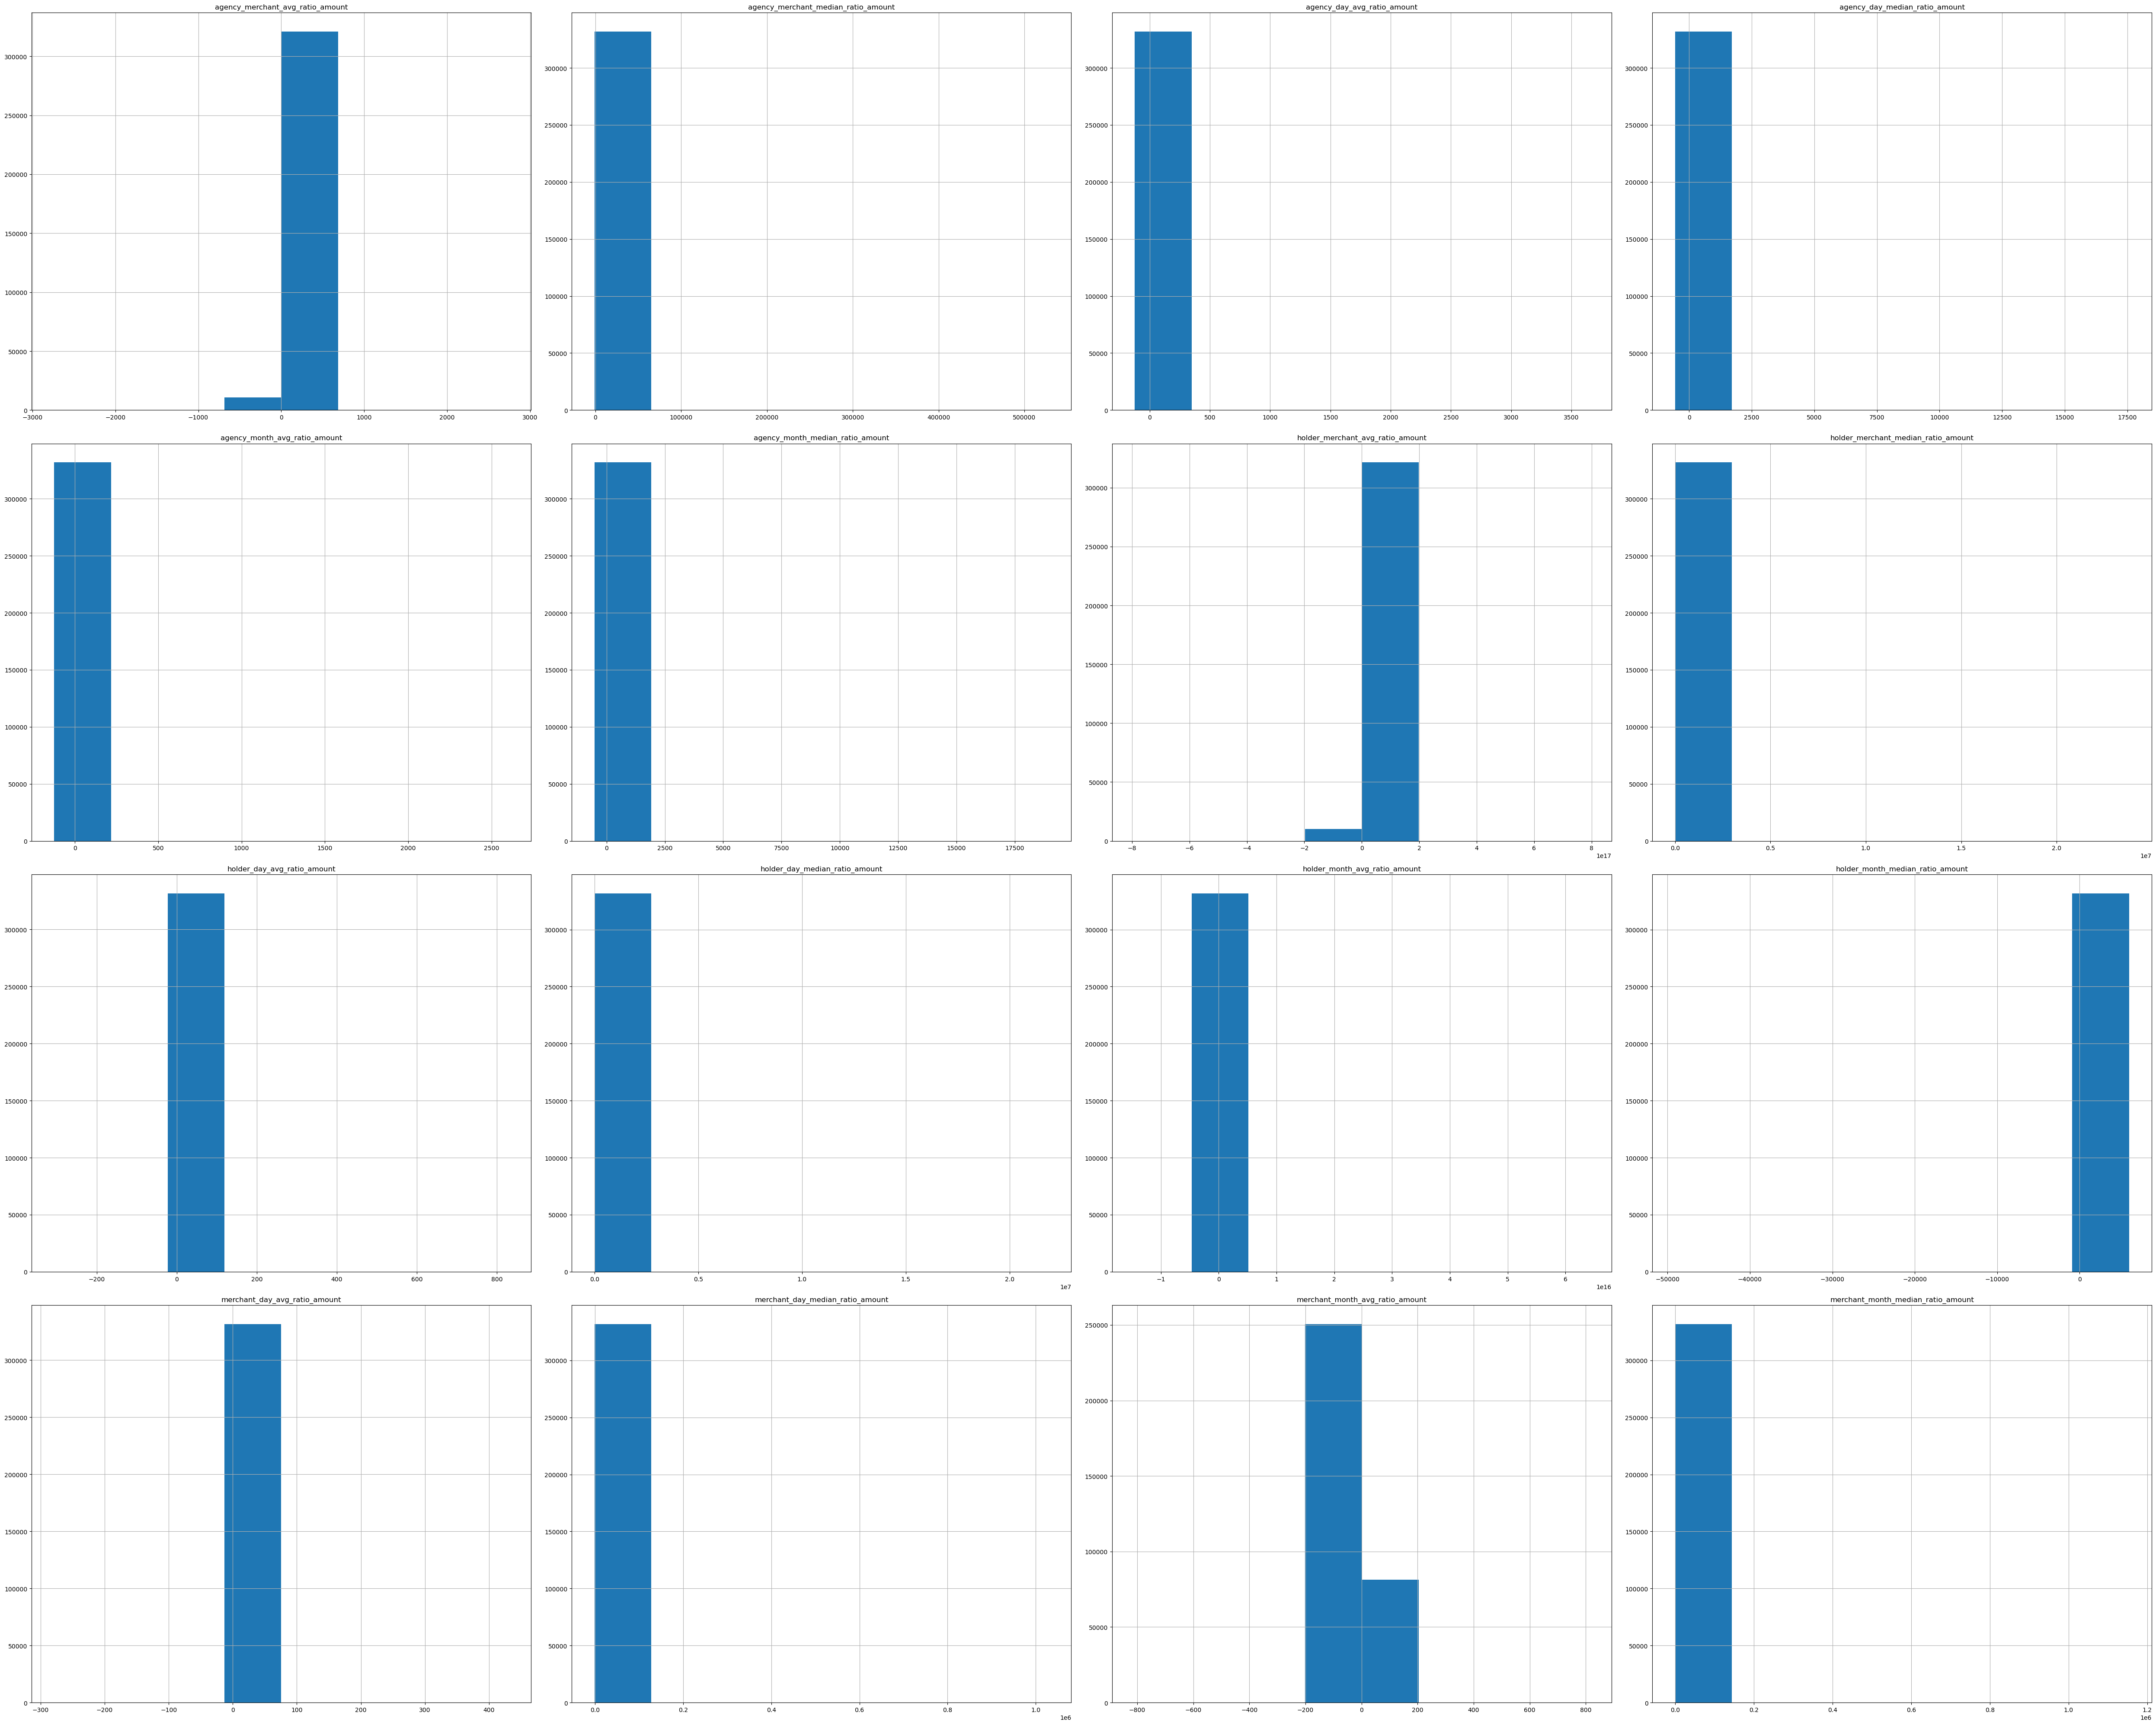

In [18]:
# Plot the distribution of all variables, setting number of bins as 8
X_train.hist(bins=8, figsize=(50, 40))
plt.tight_layout()
plt.show()

Data dispersement still cannot be clearly reflected by the plots. The issue of wide distribution with highly concerntrated values around the average but low frequency of extreme still exists. However, there are some distributions (eg. merchant_month_avg_ratio_amount) showing improvement, which is clearer dispersement display and less concertration. It indicates that data granularity is more reasonable than before.  

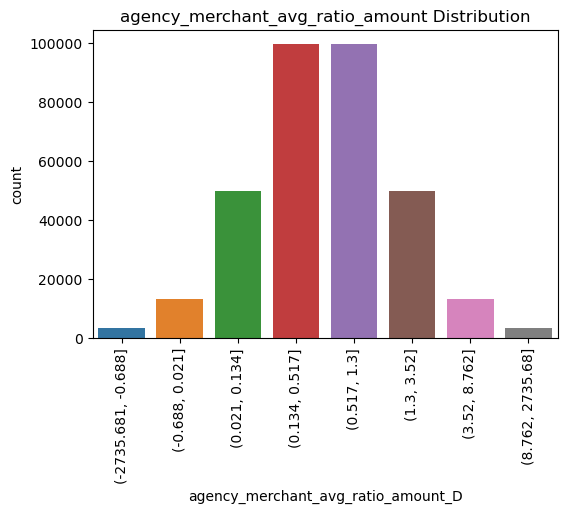

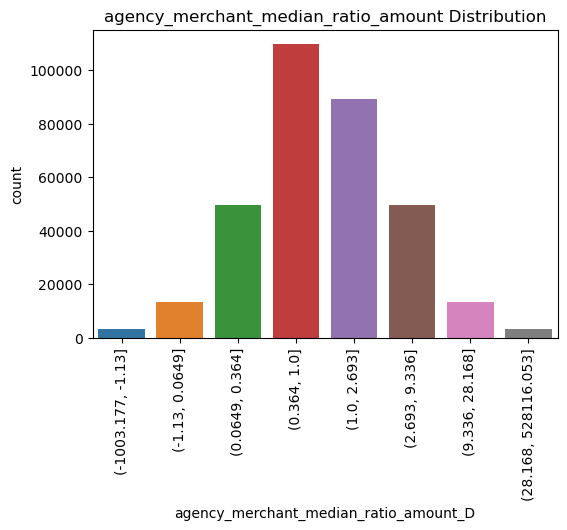

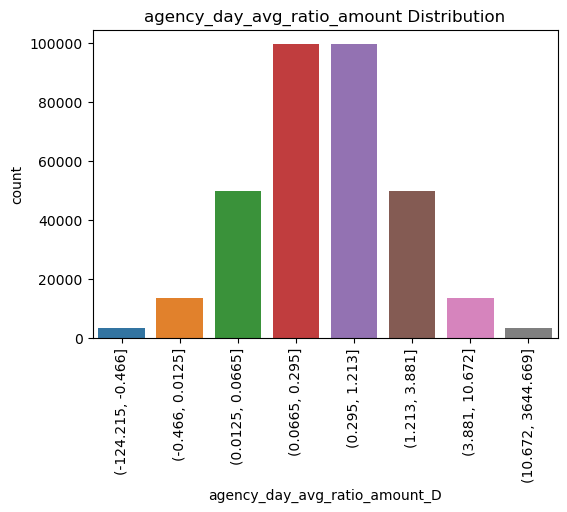

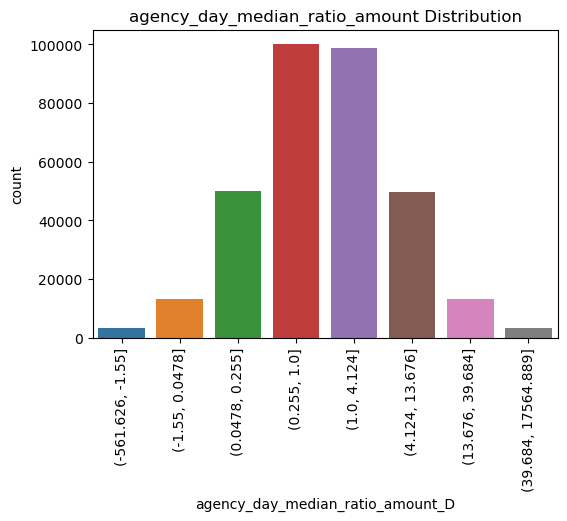

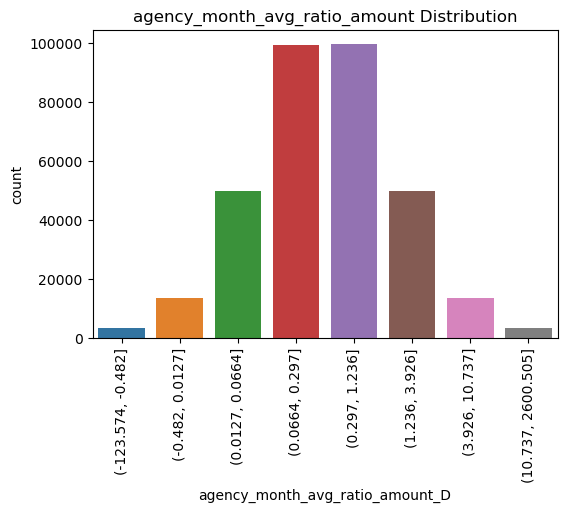

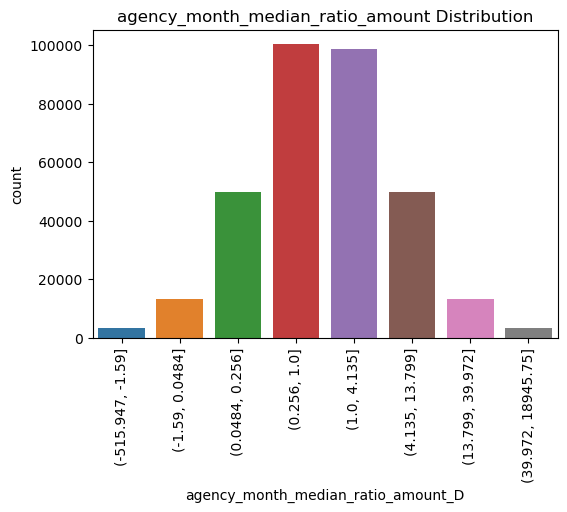

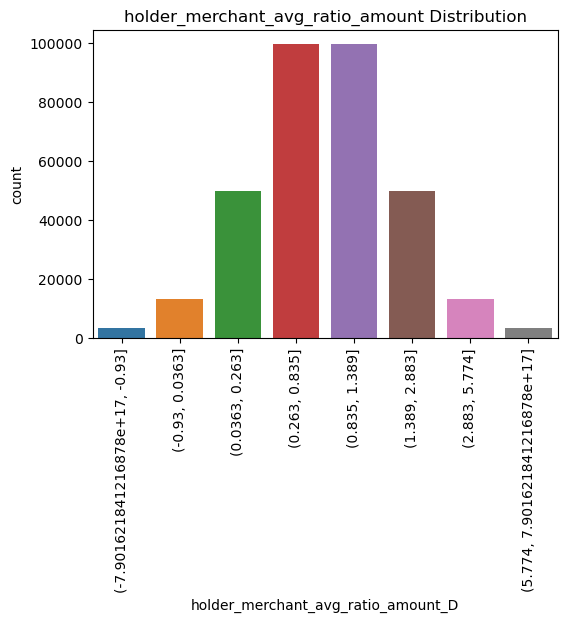

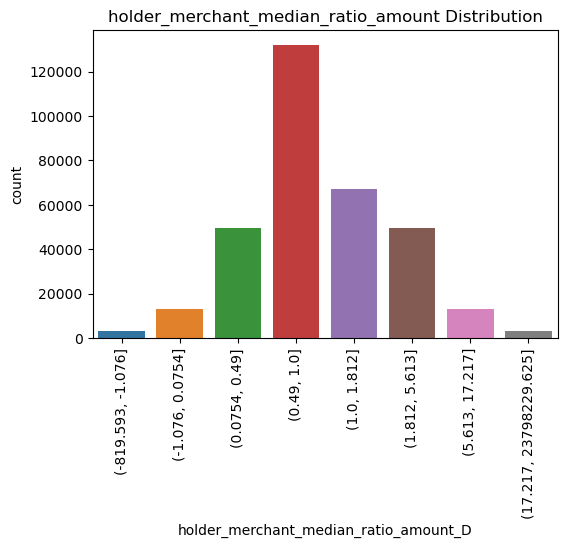

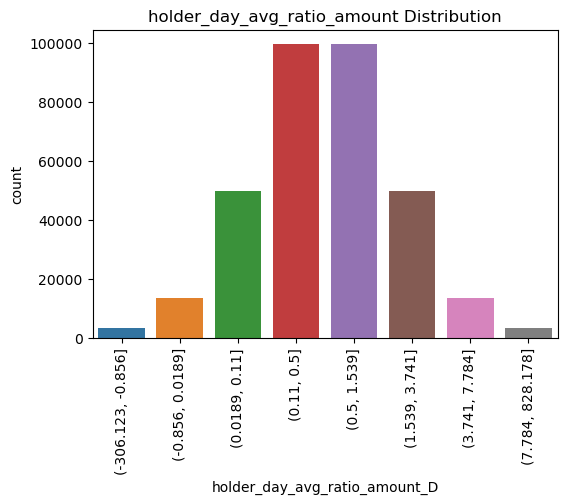

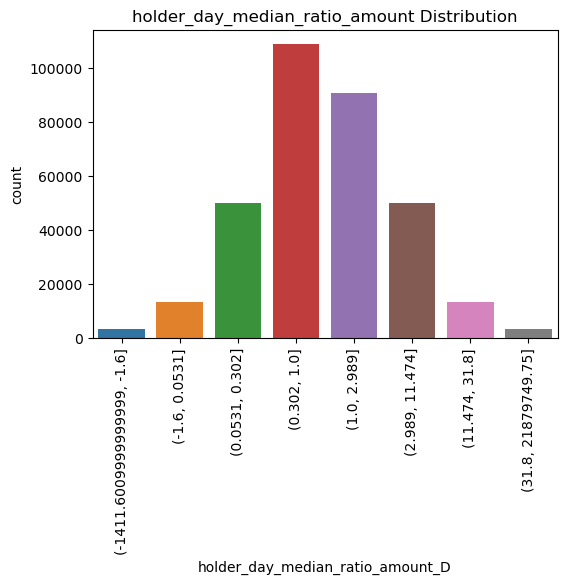

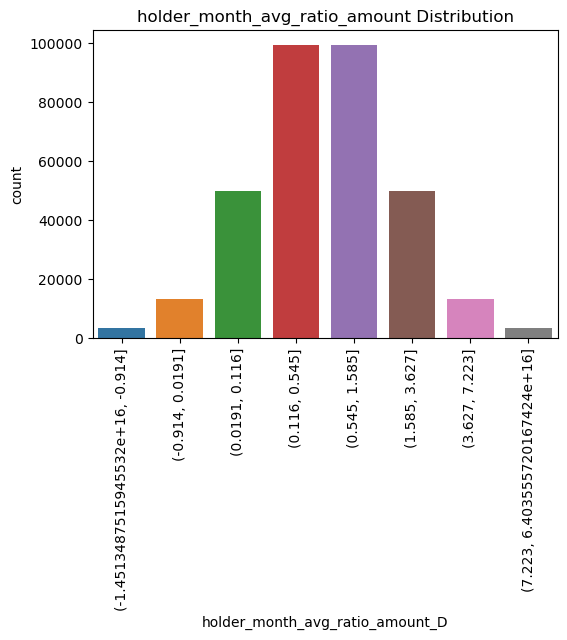

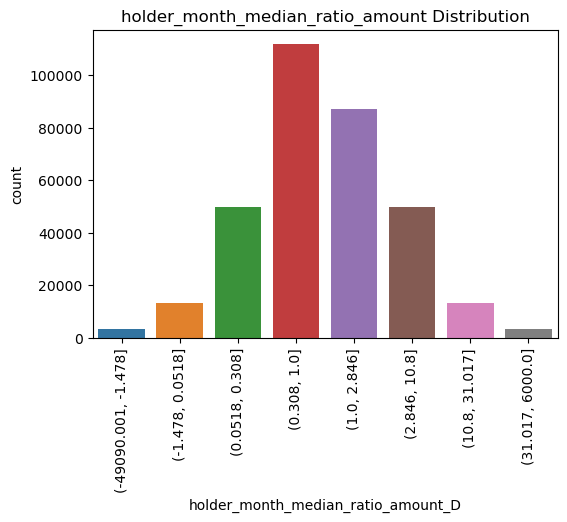

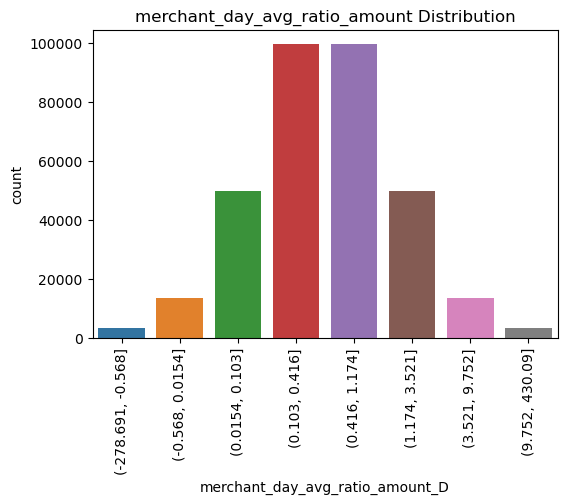

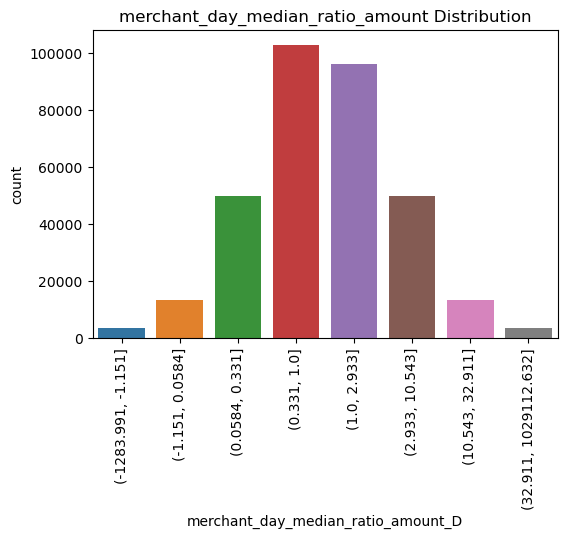

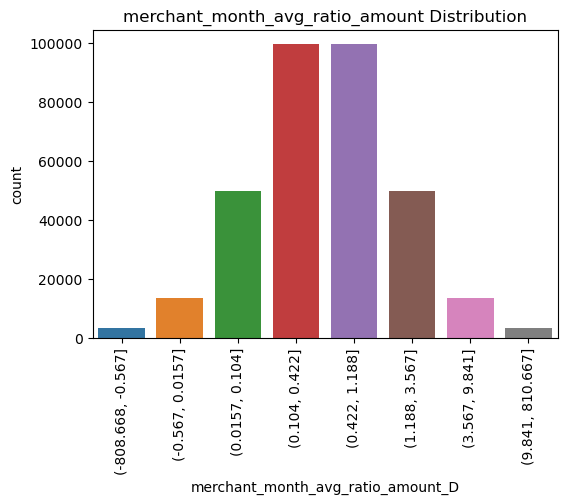

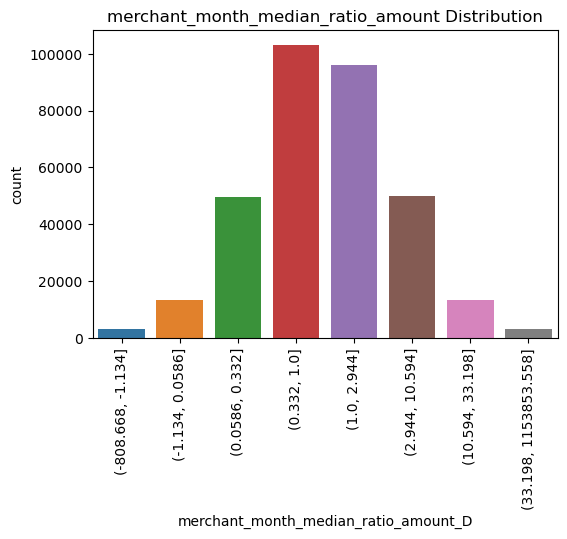

In [19]:
# Plot the distribution of all variables, binning with specific percentile 
X_train_D=X_train.copy()
for col in X_train_D.select_dtypes(include='number').columns:
    binned_var = col + '_D'

    # Sepefic percentiles: 
    ## 0 and 1 represent the minimum and maximum values
    ## 0.01, 0.05, 0.95, and 0.99 identify nearly extreme values (outliers)
    ## 0.2, 0.5, and 0.8 represent near quartiles values 
    percentile = [0, 0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99, 1]
    
    X_train_D[binned_var] = pd.qcut(X_train_D[col], percentile)
    plt.figure(figsize=(6, 4))
    g = sns.countplot(x=binned_var, data=X_train_D)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(col + ' Distribution')
    plt.show()

The specific percentile makes ourlier clearly shown. The distributions are still similar as before. We will further analyse the outliers in each variable later. 

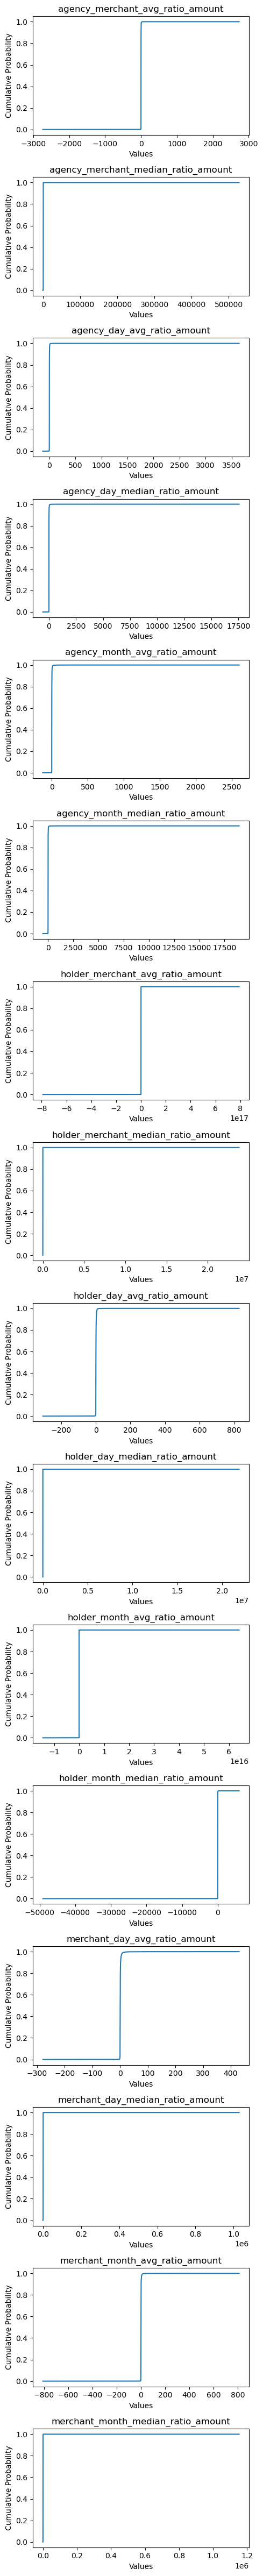

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF

# Get the list of numeric columns
numeric_cols = X_train.select_dtypes(include='number').columns

# Create separate plots for each numeric variable
num_plots = len(numeric_cols)
fig, axes = plt.subplots(num_plots, 1, figsize=(5, 3*num_plots))

# Plot the CDF for each numeric column
for i, col in enumerate(numeric_cols):
    # Fit the ECDF
    ecdf = ECDF(X_train[col])
    
    # Plot the CDF in the corresponding subplot
    axes[i].plot(ecdf.x, ecdf.y)
    axes[i].set_title(col)
    
    # Set the x and y labels for each plot
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Cumulative Probability')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

CDF still shows a significant increase from nearly 0% to nealy 100%, while crossing the average value. However, we can see some changes are less sharp (eg. merchant_day_avg_ratio_amount) than before, which means the data granularity is more reasonable than previous feature engineering. 

## Section 3 Histogram-based Outlier Score (HBOS) <a class="anchor" id="3"></a>

Histogram-based Outlier Score (HBOS) is an unsupervised anomaly detection algorithm that uses histograms to model the distribution of data and calculate outlier scores. It is suitable for credit card fraud detection because it can capture both corporate and perdonal level's outliers, allowing it to detect rare and abnormal patterns in credit card transactions. Additionally, HBOS is computationally efficient, making it well-suited for real-time anomaly detection in large-scale credit card transaction datasets.

###  3.1 Build the model <a class="anchor" id="31"></a>

I will use PyOD to produce the outlier scores for the training and test data. I will also use the function predict() to predict where an observation is an outlier or not. The function predict() compares the the outlier scores with the threshold. If an outlier score is higher than the threshold, the function assigns “1” to an observation and otherwise “0”. I made a short function count_stat() to show the count of predicted “1” and “0” values.

In [42]:
from pyod.models.hbos import HBOS
n_bins = 100
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)

# Training data
y_train_scores = hbos.decision_function(X_train)
y_train_pred = hbos.predict(X_train)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , hbos.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: 50.10957808872884
The training data: {0: 318328, 1: 13515}
The training data: {0: 106186, 1: 4429}


###  3.2 Determine the threshold <a class="anchor" id="32"></a>

I plotted the histogram of outlier score. I will choose a more conservative approach by selecting a high threshold, which will result in fewer but hopefully finer outliers in the outlier group. 

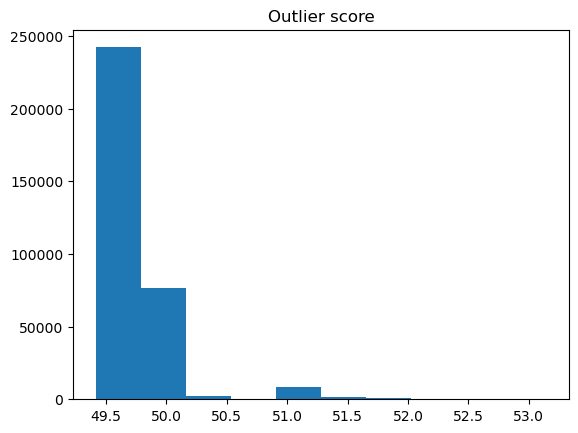

In [43]:
plt.hist(y_train_scores) 
plt.title("Outlier score")
plt.show()

The histogram suggests 50.2 to be the threshold. The selection of the threshold also determines the percentage of outliers in the population.

###  3.3 Descriptive statistics of the normal and outlier groups <a class="anchor" id="33"></a>

This step profiles the characteristics of the normal and abnormal groups. The characteristics of the outliers should be very different from the normal data. The descriptive statistic table becomes a good metric to prove the soundness of a model. I will show the count percentage of the normal and outlier groups, as well as their the average values of each feature in the tables below.

In [44]:
threshold = 50.2 

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_avg_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_avg_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,318513,95.98304,0.78,1.79,0.70,2.43,0.70,2.44,4.624343e+12,1.52,0.87,2.24,1.970295e+11,1.95,0.66,1.81,0.68,1.84,49.61
1,Outlier,13330,4.01696,6.41,100.17,8.58,38.49,8.34,38.42,-1.783086e+14,3436.59,4.16,1660.20,-1.088784e+12,16.94,9.32,184.04,8.90,202.54,51.05


In [25]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_avg_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_avg_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,106259,96.062017,0.78,1.77,0.69,2.41,0.70,2.43,8.209704e+12,1.46,0.87,2.21,-6.026366e+11,2.28,0.65,1.81,0.67,1.84,49.61
1,Outlier,4356,3.937983,6.25,22.54,7.41,31.27,7.44,31.67,7.250961e+12,9.45,4.21,18.62,3.625481e+12,15.75,8.87,30.94,8.50,30.31,51.04


From the above tables, we can see these common patterns for both training and testing datasets:
- Size of the outlier group: 
Using 50.2 as score threshold, around 4% of transactions are identified as outliers, while the remaining 96% of transactions drops into the normal group. 
- Average anomaly score: 
The average HBO score of the outlier group is higher than that of the normal group. This evidence just verifies the data in the outlier group are outliers. 
- Feature statistics - Corporate spending patterns:
    1. Grouping by agency + merchant category: 
    The outlier group has much higher values of <b>'agency_merchant_avg_ratio_amount'</b> and <b>'agency_merchant_median_ratio_amount'</b> than those of the normal group, because of the type of necessary business spending. Employees from the same organisation should spend similar amount in the same merchant category. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    2. Grouping by agency + day of week:
    The outlier group has much higher values of <b>'agency_day_avg_ratio_amount'</b> and <b>'agency_day_median_ratio_amount'</b> than those of the normal group. Employees from the same organisation should spend similar amount in the same day of week, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    3. Grouping by agency + month:
    The outlier group has much higher values of <b>'agency_month_avg_ratio_amount'</b> and <b>'agency_month_median_ratio_amount'</b> than those of the normal group. Employees from the same organisation should spend similar amount in the same month, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
- Feature statistics - Personal spending patterns:
    4. Grouping by card holder + merchant category:
    The outlier group has much higher values of <b>'holder_merchant_median_ratio_amount'</b> than those of the normal group. A person should spend similar amount in the same merchant category, because of the type of necessary business spending. It is suspicious if the transaction amount is much higher than the median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of this feature statistics between outlier and normal group helps to make sense of the model results.
    However, the feature statistics of <b>holder_merchant_avg_ratio_amount</b> cannot be properly explained. In training dataset, the outlier group has a largely negative average value. In testing dataset, the outlier group has a smaller average value than the normal group. However, this feature should have a higher average value for outlier group than the normal, with similar reason as 'holder_merchant_median_ratio_amount'. Therefore, I will drop this feature from modeling. 
    5. Grouping by card holder + day of week:
    The outlier group has much higher values of <b>'holder_day_avg_ratio_amount'</b> and <b>'holder_day_median_ratio_amount'</b> than those of the normal group. A person should spend similar amount in the same day of week, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    6. Grouping by card holder + month
    The outlier group has much higher values of <b>'holder_month_median_ratio_amount'</b> than those of the normal group. A person should spend similar amount in the same month, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of this feature statistics between outlier and normal group helps to make sense of the model results.
    However, the feature statistics of <b>holder_month_avg_ratio_amount</b> cannot be properly explained. In testing dataset, the outlier group has a largely negative average value. In training dataset, the outlier group has a smaller and even negative average value than the normal group. However, this feature should have a higher average value for outlier group than the normal, with similar reason as 'holder_month_median_ratio_amount'. Therefore, I will drop this feature from modeling. 
- Feature statistics - Consuming category spending patterns:
    7. Grouping by merchant category + day of week
    The outlier group has much higher values of <b>'merchant_day_avg_ratio_amount'</b> and <b>'merchant_day_median_ratio_amount'</b> than those of the normal group. People should spend similar amount for the same merchant category in the same day of week, because of both the type of necessary business spending and the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    8. Grouping by merchant category + month 
    The outlier group has much higher values of <b>'merchant_month_avg_ratio_amount'</b> and <b>'merchant_month_median_ratio_amount'</b> than those of the normal group. People should spend similar amount for the same merchant category in the same month, because of both the type of necessary business spending and the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.

###  3.4 Fine-tuning HBOS Model <a class="anchor" id="34"></a>

####  3.4.1 Feature Selection <a class="anchor" id="341"></a>

As stated above, I will drop 'holder_merchant_avg_ratio_amount' and 'holder_month_avg_ratio_amount' to make sense of the model. 

In [58]:
X_train = X_train_copy.drop(['holder_merchant_avg_ratio_amount', 'holder_month_avg_ratio_amount'], axis=1)
X_test = X_test_copy.drop(['holder_merchant_avg_ratio_amount', 'holder_month_avg_ratio_amount'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [51]:
n_bins = 100
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)

# Training data
y_train_scores = hbos.decision_function(X_train)
y_train_pred = hbos.predict(X_train)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , hbos.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: 43.465721898954136
The training data: {0: 318328, 1: 13515}
The training data: {0: 106186, 1: 4429}


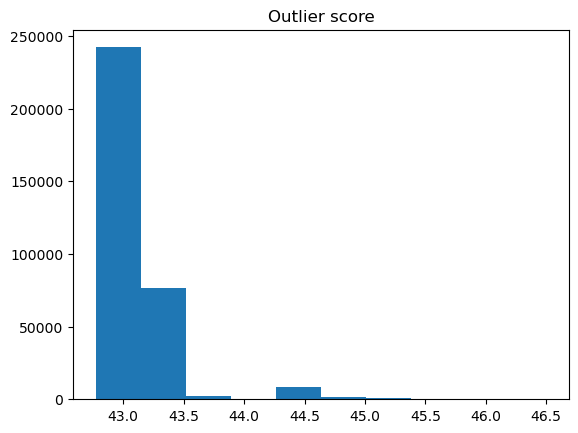

In [52]:
plt.hist(y_train_scores) 
plt.title("Outlier score")
plt.show()

The histogram suggests 43.5 to be the threshold.

In [53]:
threshold = 43.5

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,318353,95.934825,0.78,1.79,0.70,2.43,0.70,2.45,1.52,0.87,2.24,1.95,0.66,1.81,0.68,1.84,42.97
1,Outlier,13490,4.065175,6.34,98.99,8.48,38.01,8.24,37.95,3395.84,4.15,1640.55,16.76,9.21,181.87,8.79,200.15,44.39


In [54]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,106195,96.004159,0.77,1.77,0.69,2.41,0.70,2.43,1.46,0.87,2.21,2.28,0.65,1.81,0.67,1.84,42.96
1,Outlier,4420,3.995841,6.18,22.28,7.31,30.90,7.33,31.30,9.38,4.23,18.39,15.56,8.75,30.51,8.38,29.88,44.38


From the above tables, we can see these common patterns for both training and testing datasets:
- Size of the outlier group: 
Using 43.5 as score threshold, around 4% of transactions are identified as outliers, while the remaining 96% of transactions drops into the normal group. 
- Average anomaly score: 
The average HBO score of the outlier group is higher than that of the normal group. This evidence just verifies the data in the outlier group are outliers. 
- Feature statistics: 
All features show a higher average value for the outlier group than the normal group, which is reasonable because a significant larger transaction amount than the the same group indicates the transaction is suspicious. All the feature statistics can make sense of the model results.

####  3.4.2 Testing number of bins  <a class="anchor" id="342"></a>
To fine tune the hyperparameters and make a better anolmaly detection performance, I have tested a range of the number of bins and plotted them as below. 

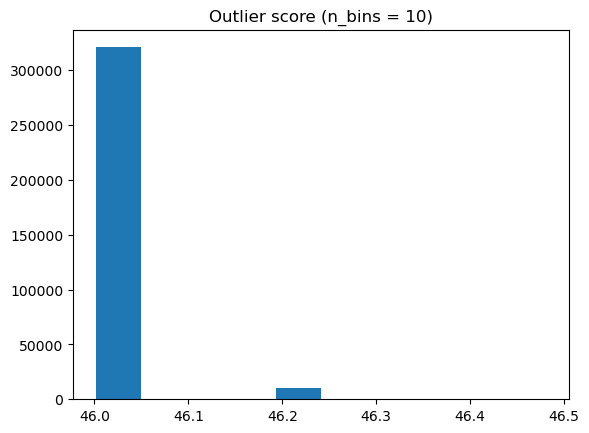

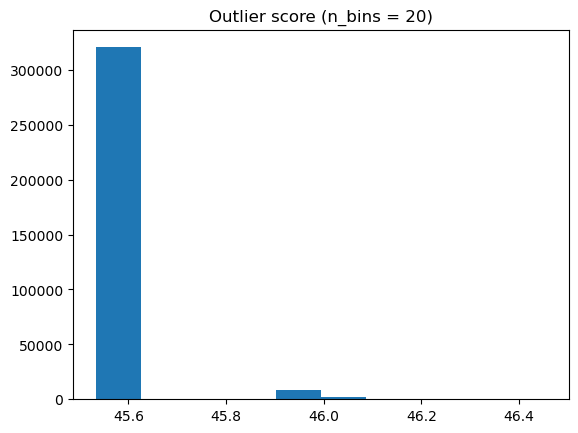

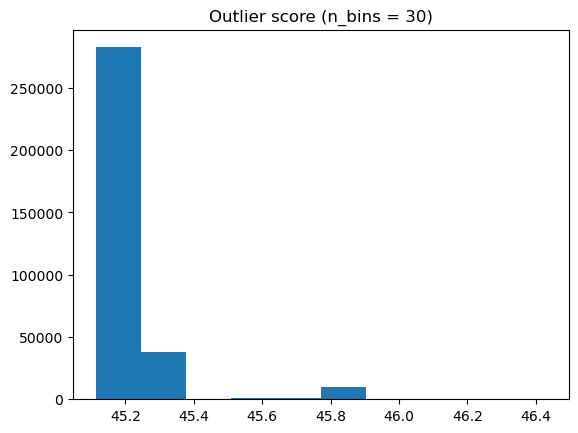

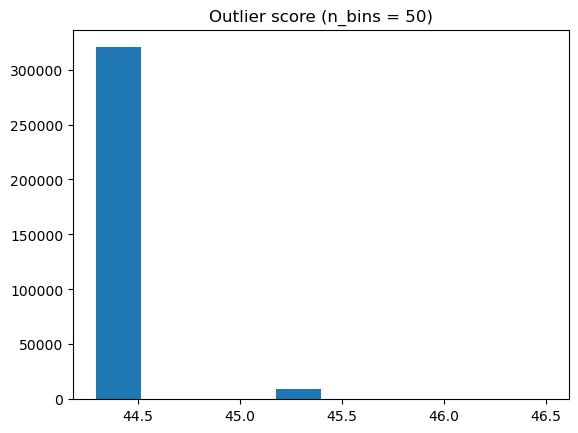

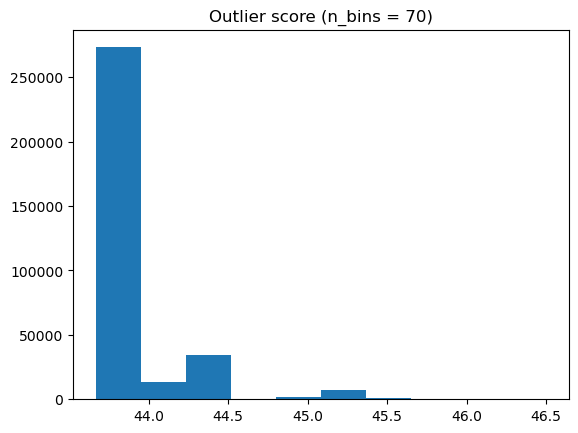

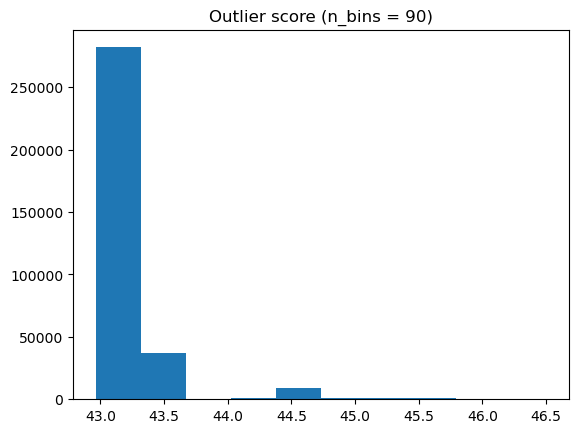

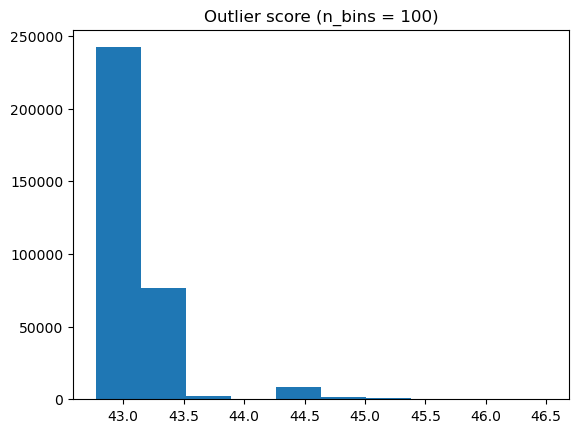

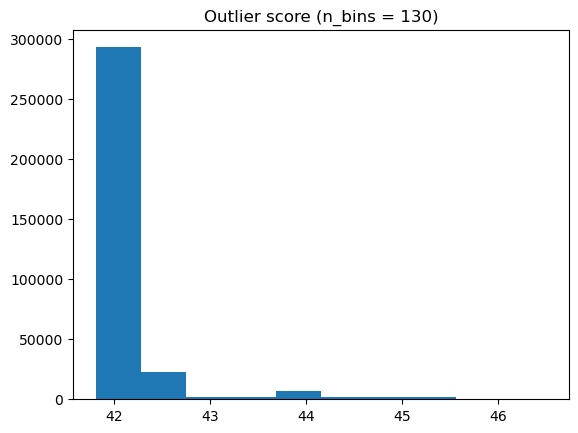

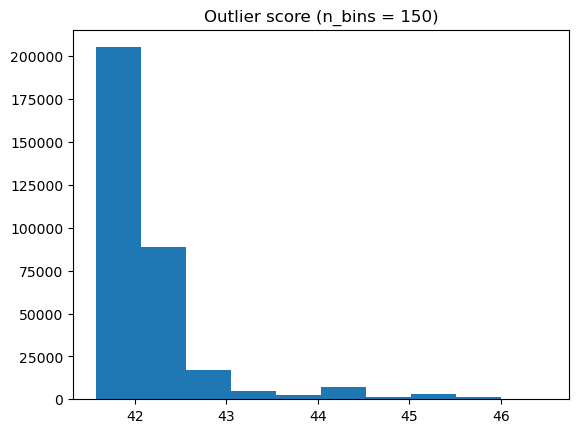

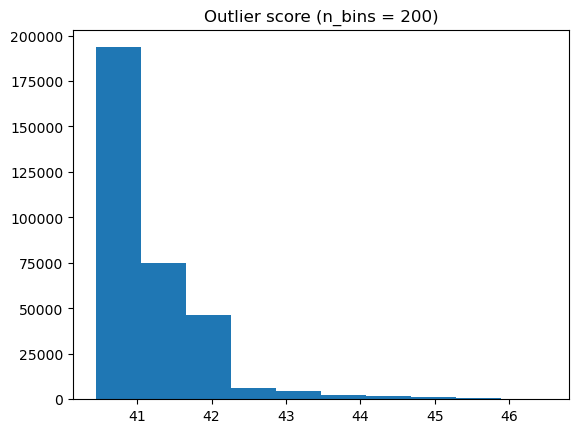

In [59]:
X_train = X_train_copy.copy()

def plot_outlier_scores(X_train, n_bins_list):
    for n_bins in n_bins_list:
        hbos = HBOS(n_bins=n_bins, contamination=0.05)
        hbos.fit(X_train)
        y_train_scores = hbos.decision_function(X_train)

        plt.hist(y_train_scores)
        plt.title("Outlier score (n_bins = {})".format(n_bins))
        plt.show()

n_bins_list = [10, 20, 30, 50, 70, 90, 100, 130, 150, 200]
plot_outlier_scores(X_train, n_bins_list)

The results show that number of bins as 100 can make HBOS model reflect both the clear cut and dispersed distribution of scores. Therefore, I will use 100 as the number of bins used for histogram construction in HBOS modeling. 

###  3.5 Achieve model stability by aggregating multiple models <a class="anchor" id="35"></a>

HBOS can be sensitive to the bin width of the histogram. If the bins are too narrow, the normal data points falling in these bins will be identified as outliers. If the bins are too wide, outliers will fall into the bins of the normal data and be overlooked. To produce a model with a stable outcome, the strategy is to build HBOS models with a range of histogram widths to obtain multiple scores and then aggregate the scores. This approach will reduce the chance of overfitting and increase prediction accuracy. 

In [60]:
X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of binning 
k_list = [10, 20, 30, 50, 70, 90, 100, 130, 150, 200]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=k)
    hbos.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = hbos.decision_function(X_train_norm) 
    test_scores[:, i] = hbos.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

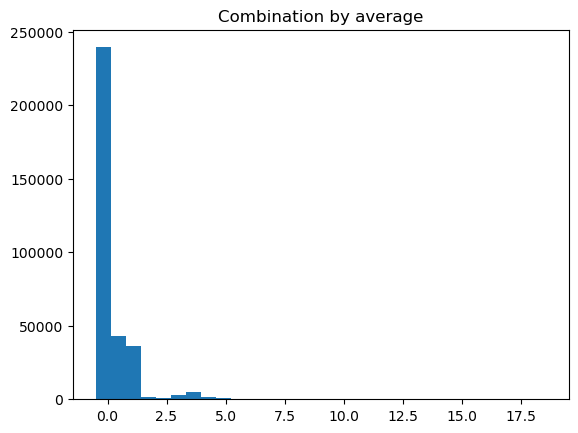

In [61]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='doane') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [70]:
descriptive_stat_threshold(X_train,y_train_by_average, 1.5)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,318932,96.109305,0.78,1.78,0.69,2.37,0.70,2.39,1.52,0.86,2.21,1.89,0.66,1.81,0.68,1.84,-0.15
1,Outlier,12911,3.890695,6.57,103.52,9.06,41.01,8.78,40.90,3548.18,4.42,1714.67,18.92,9.58,189.98,9.07,209.05,3.73


In [71]:
descriptive_stat_threshold(X_test,y_test_by_average, 1.5)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,106390,96.180446,0.77,1.76,0.68,2.35,0.69,2.37,1.46,0.86,2.18,2.14,0.65,1.81,0.67,1.83,-0.15
1,Outlier,4225,3.819554,6.46,23.37,7.86,33.70,7.86,34.08,9.65,4.53,19.92,19.68,9.12,31.92,8.72,31.27,3.69


From the above tables, we can see these common patterns for both training and testing datasets:
- Size of the outlier group: 
Using 1.5 as score threshold, around 4% of transactions are identified as outliers, while the remaining 96% of transactions drops into the normal group. 
- Average anomaly score: 
The average HBO score of the outlier group is higher than that of the normal group. This evidence just verifies the data in the outlier group are outliers. 
- Feature statistics: 
All features show a higher average value for the outlier group than the normal group, which is reasonable because a significant larger transaction amount than the the same group indicates the transaction is suspicious. All the feature statistics can make sense of the model results.

## Section 4 Empirical Cumulative Outlier Detection (ECOD) <a class="anchor" id="4"></a>

Empirical Cumulative Outlier Detection (ECOD) is an unsupervised anomaly detection algorithm that measures the connectivity of data points in a high-dimensional space. It is suitable for credit card fraud detection because it can capture complex and non-linear relationships among features, enabling the detection of fraudulent patterns that may not be captured by traditional methods. ECOD's ability to model the intrinsic structure of the data makes it effective in identifying anomalous credit card transactions.

###  4.1 Build the model <a class="anchor" id="41"></a>

Below we declare and fit the model, then use PyOD to generate the outlier scores for the training and test data. The parameter contamination=0.05 declares the percentage of outliers to be 5%. The contamination parameter does not affect the calculation of the outlier scores.
PyOD uses the given contamination rate to derive the threshold for the outlier scores, and applies the function predict() to assign the labels (1 or 0).
I made a short function count_stat() in the code below to show the count of predicted “1” and “0” values.
The threshold at the assigned contamination rate also has been shown. Any outlier score higher than the threshold is considered an outlier.

In [67]:
X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

from pyod.models.ecod import ECOD
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)

# Training data
y_train_scores = ecod.decision_function(X_train)
y_train_pred = ecod.predict(X_train)

# Test data
y_test_scores = ecod.decision_function(X_test)
y_test_pred = ecod.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ecod.threshold_)

The training data: {0: 315250, 1: 16593}
The training data: {0: 105206, 1: 5409}
The threshold for the defined comtanimation rate: 49.67362896790177


###  4.2 Determine the threshold<a class="anchor" id="42"></a>

I plotted the histogram of outlier score. I will choose a more conservative approach by selecting a high threshold, which will result in fewer but hopefully finer outliers in the outlier group.

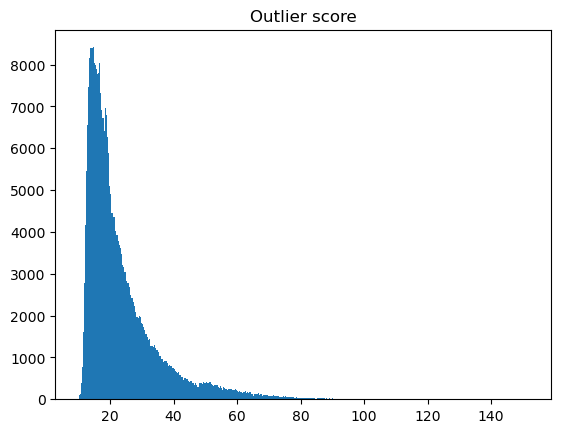

In [68]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

The histogram suggests 50 to be the threshold. The selection of the threshold also determines the percentage of outliers in the population.

###  4.3 Descriptive statistics <a class="anchor" id="43"></a>

This step profiles the characteristics of the normal and abnormal groups. The characteristics of the outliers should be very different from the normal data. The descriptive statistic table becomes a good metric to prove the soundness of a model. I will show the count percentage of the normal and outlier groups, as well as their the average values of each feature in the tables below.

In [77]:
threshold = 50

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,315643,95.118173,0.88,2.02,0.77,2.72,0.78,2.74,1.62,0.93,2.41,2.07,0.79,2.17,0.80,2.18,21.64
1,Outlier,16200,4.881827,3.44,78.25,5.73,26.40,5.51,26.33,2826.05,2.31,1363.10,11.93,5.31,144.85,5.06,160.39,62.18


In [78]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_day_avg_ratio_amount,agency_day_median_ratio_amount,agency_month_avg_ratio_amount,agency_month_median_ratio_amount,holder_merchant_median_ratio_amount,holder_day_avg_ratio_amount,holder_day_median_ratio_amount,holder_month_median_ratio_amount,merchant_day_avg_ratio_amount,merchant_day_median_ratio_amount,merchant_month_avg_ratio_amount,merchant_month_median_ratio_amount,Anomaly_Score
0,Normal,105344,95.234823,0.88,2.00,0.77,2.69,0.78,2.71,1.56,0.93,2.39,2.31,0.78,2.16,0.79,2.17,21.64
1,Outlier,5271,4.765177,3.28,14.29,4.77,20.59,4.77,20.94,6.00,2.36,12.15,12.79,4.91,18.96,4.78,18.79,62.01


From the above tables, we can see these common patterns for both training and testing datasets:

- Size of the outlier group: Using 50 as score threshold, around 5% of transactions are identified as outliers, while the remaining 95% of transactions drops into the normal group.
- Average anomaly score: The average ECOD score of the outlier group is higher than that of the normal group. This evidence just verifies the data in the outlier group are outliers.
- Feature statistics - Corporate spending patterns:
    1. Grouping by agency + merchant category: The outlier group has much higher values of 'agency_merchant_avg_ratio_amount' and 'agency_merchant_median_ratio_amount' than those of the normal group, because of the type of necessary business spending. Employees from the same organisation should spend similar amount in the same merchant category. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    2. Grouping by agency + day of week: The outlier group has much higher values of 'agency_day_avg_ratio_amount' and 'agency_day_median_ratio_amount' than those of the normal group. Employees from the same organisation should spend similar amount in the same day of week, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    3. Grouping by agency + month: The outlier group has much higher values of 'agency_month_avg_ratio_amount' and 'agency_month_median_ratio_amount' than those of the normal group. Employees from the same organisation should spend similar amount in the same month, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
- Feature statistics - Personal spending patterns:
    1. Grouping by card holder + merchant category: The outlier group has much higher values of 'holder_merchant_median_ratio_amount' than those of the normal group. A person should spend similar amount in the same merchant category, because of the type of necessary business spending. It is suspicious if the transaction amount is much higher than the median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of this feature statistics between outlier and normal group helps to make sense of the model results. 
    2. Grouping by card holder + day of week: The outlier group has much higher values of 'holder_day_avg_ratio_amount' and 'holder_day_median_ratio_amount' than those of the normal group. A person should spend similar amount in the same day of week, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    3. Grouping by card holder + month The outlier group has much higher values of 'holder_month_median_ratio_amount' than those of the normal group. A person should spend similar amount in the same month, because of the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of this feature statistics between outlier and normal group helps to make sense of the model results. 
- Feature statistics - Consuming category spending patterns:
    1. Grouping by merchant category + day of week The outlier group has much higher values of 'merchant_day_avg_ratio_amount' and 'merchant_day_median_ratio_amount' than those of the normal group. People should spend similar amount for the same merchant category in the same day of week, because of both the type of necessary business spending and the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.
    2. Grouping by merchant category + month The outlier group has much higher values of 'merchant_month_avg_ratio_amount' and 'merchant_month_median_ratio_amount' than those of the normal group. People should spend similar amount for the same merchant category in the same month, because of both the type of necessary business spending and the business activities' time frame pattern. It is suspicious if the transaction amount is much higher than the average or median amount of the same group. Therefore, these outliers should be investigated as fraud alerts. The comparison of these 2 feature statistics between outlier and normal group helps to make sense of the model results.

## Section 5 Conclusion <a class="anchor" id="5"></a>

###  5.1 Outliers Identified by Multiple Models <a class="anchor" id="51"></a>

We have used two models HBOS and ECOD in the previous and this chapters. If an outlier is identified by multiple models, the chance that it is an outlier is much higher. In this section, I am going to cross-tabulate the predictions of the two models to identify outliers. I first replicate the HBOS and ECOD models and generate their thresholds.

In [108]:
X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

########
# HBOS #
########
n_bins = 100
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)
y_train_hbos_pred = hbos.labels_
y_test_hbos_pred = hbos.predict(X_test)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

########
# ECOD #
########
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_train_ecod_pred = ecod.labels_
y_test_ecod_pred = ecod.predict(X_test)
y_train_ecod_scores = ecod.decision_scores_  # raw outlier scores
y_test_ecod_scores = ecod.decision_function(X_test)

# Thresholds
[ecod.threshold_, hbos.threshold_]

[49.67362896790177, 43.465721898954136]

I put the actual Y value, and the predicted “1” and “0” values by HBOS and ECOD together in a data frame. When I cross-tabulate the HBOS and the ECOD predictions, 2271 observations are identified by both models to be outliers. Both ECOD and HBOS yield consistent results.

In [109]:
# Put the actual, the HBO score and the ECOD score together
Actual_pred = pd.DataFrame({'HBOS_pred': y_test_hbos_pred, 'ECOD_pred': y_test_ecod_pred})
Actual_pred.head()
pd.crosstab(Actual_pred['HBOS_pred'],Actual_pred['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,103048,3138
1,2158,2271


###  5.2 Explain the Outlier Score of an Observation <a class="anchor" id="52"></a>

Finally, I extracted the transactions that are identified as outliers by both models, and visualize the univariate scores to understand why an outlier has a high ECOD score. Such interpretability for individual predictions is important in machine learning. 

In [115]:
np.where((y_train_ecod_scores > 50) & (y_train_hbos_scores > 44))

(array([    61,     87,    115, ..., 331814, 331828, 331831]),)

I plot the univariate outlier scores for one observation in the below figure. The x-axis is the dimension and the y-axis is the univariate outlier score. The blue and orange dashed lines are the 95 and 99 percentiles for outlier scores. 

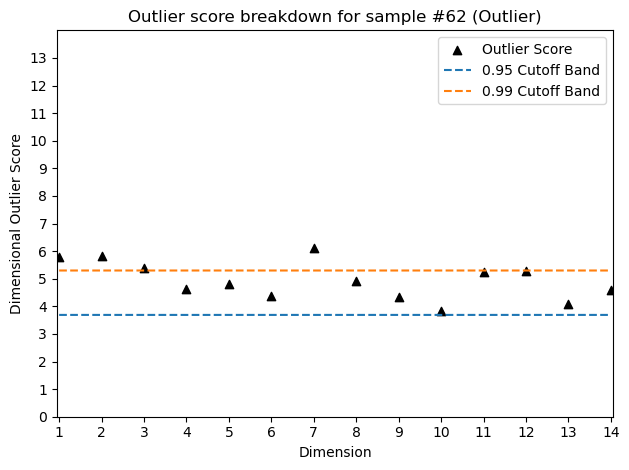

In [116]:
ecod.explain_outlier(61)

The above plot is the investigation for the 62nd sample, which is identified as outlier by both models. All of the features have outlier scores that drop out of the 95% cutoff band, and 4 features ('agency_merchant_avg_ratio_amount', 'agency_merchant_median_ratio_amount', 'agency_day_avg_ratio_amount', 'holder_merchant_median_ratio_amount') drop out of 99% cutoff band. This explainability for the outlier scores is a plausible property of ECOD.